In [1]:
import os, yaml
import numpy as np
import awkward as ak
import scipy as sp
import scipy.stats as sps

import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh
# import ROOT
from scipy.interpolate import CubicSpline
from coffea.nanoevents import NanoEventsFactory, BaseSchema



/data/bond/fudawei/anaconda3/lib/python3.12/site-packages/coffea/nanoevents/schemas/fcc.py:5: FutureWarning: In version 2025.1.0 (target date: 2024-12-31 11:59:59-06:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  from coffea.nanoevents.methods import vector


# Functions

In [243]:
def Garwood_eror(number, direction):
    upper = np.array([1.84, 3.30, 4.64, 5.92, 7.16, 8.38, 9.58, 10.77, 11.95, 13.11, 14.27])
    lower = np.array([0, 0.17, 0.71, 1.37, 2.09, 2.84, 3.62, 4.42, 5.23, 6.06, 6.89])
    center = np.arange(11)
    if number < 0:
        raise ValueError('number < 0 !')
    elif number > 10:
        return np.sqrt(number)
    elif direction=='up':
        return (upper-center)[int(number)]
    elif direction=='down':
        return (center-lower)[int(number)]
    else:
        return None

In [244]:
line_color = {'expow1': ROOT.kRed, 'expow2': ROOT.kGreen+1, 'dijet2': ROOT.kYellow+2, 'dijet3': ROOT.kCyan, 'invpow2':ROOT.kBlue, 'invpow3': ROOT.kMagenta}
band_color = {'expow1': ROOT.kPink, 'expow2': ROOT.kYellow, 'dijet2': ROOT.kGreen, 'dijet3': ROOT.kCyan, 'invpow2':ROOT.kAzure, 'invpow3': ROOT.kMagenta}


def fit_error_band(candidates, model, result, fit_variable, data_region, SR, jet, x_min=650, x_max=3700, bin_width=50, line_color=line_color):
    ## plot
    bins = int((x_max-x_min)/bin_width)
    plot_name = (candidates[0] if len(candidates) == 1 else f"{len(candidates)}")

    # Create a canvas and split it into two pads
    canvas = ROOT.TCanvas("canvas", "canvas", 800, 800)
    top_pad = ROOT.TPad("top_pad", "top_pad", 0, 0.3, 1, 1)  # Top pad (main plot)
    bottom_pad = ROOT.TPad("bottom_pad", "bottom_pad", 0, 0, 1, 0.3)  # Bottom pad (pull plot)
    top_pad.Draw()
    bottom_pad.Draw()


    # Draw the main plot in the top pad
    top_pad.cd()
    top_pad.SetLogy()
    top_pad.SetBottomMargin(0.02)  # Reduce margin between pads

    legend = ROOT.TLegend(0.35, 0.6, 0.89, 0.89)
    legend.SetBorderSize(0)
    legend.SetNColumns(2)
    legend.SetTextSize(0.03)
    #legend.SetFillColorAlpha(ROOT.kWhite, 0)

    frame = fit_variable.frame(x_min, x_max, bins)

    # Create a histogram from the RooDataSet
    hist_data = data_region.createHistogram(f"hist_data", fit_variable, ROOT.RooFit.Binning(bins, x_min, x_max))

    # Convert the histogram to a RooHist object
    data_hist = ROOT.RooHist(hist_data)
    for i in range(data_hist.GetN()):
        y = data_hist.GetPointY(i)
        data_hist.SetPointError(i, 0, 0, Garwood_eror(y, 'down'), Garwood_eror(y, 'up'))
    data_region.plotOn(frame, ROOT.RooFit.MarkerColor(ROOT.kBlack), ROOT.RooFit.LineColor(ROOT.kWhite))
    
    # plot errorbands
    for k in candidates:
        model[k].plotOn(frame, VisualizeError=(result[k], 1), FillColor='kGray', LineColor='kWhite', Name=f'error_{k}')
    
    for i, k in enumerate(candidates):
        model[k].plotOn(frame, LineColor=line_color[k], Name=k)
        chi2_ndf = frame.chiSquare(len(result[k].floatParsFinal()))
        legend.AddEntry(frame.getObject(i+len(candidates)+1), f"{k}, #chi^{{2}}/NDF = {chi2_ndf:.2f}", "l")
    frame.addPlotable(data_hist, "P")
    legend.AddEntry(frame.getObject(2*len(candidates)+1), "Data", "ep")
    legend.AddEntry(frame.getObject(1), '#sigma_{SYS}', "f")
    #return bins
    hpull = frame.pullHist(frame.getObject(2*len(candidates)+1).GetName(), frame.getObject(len(candidates)+1).GetName())
    for i in range(hpull.GetN()):
        hpull.SetPointError(i, 0, 0, 1, 1)  # Set x-error to 0 and y-error to 1return frame.getObject(2)
    
    canvas.SetLogy()
    frame.SetMinimum(1e-2)
    frame.SetTitle("")
    frame.GetXaxis().SetLabelSize(0)  # Hide x-axis labels
    frame.GetXaxis().SetTickLength(0) # Hide x-axis ticks
    #frame.GetXaxis().SetTitle('m_{j\gamma} [GeV]')
    frame.Draw()
    legend.Draw()
    
    ##########################################
    # Draw the pull plot in the bottom pad

    bottom_pad.cd()
    bottom_pad.SetTopMargin(0.04)  # Reduce margin between pads
    bottom_pad.SetBottomMargin(0.25)  # Increase bottom margin for labels

    bottom_legend = ROOT.TLegend(0.3, 0.25, 0.95, 0.5)
    #legend.SetTextSize(0.05)
    bottom_legend.SetBorderSize(0)
    bottom_legend.SetFillColorAlpha(ROOT.kWhite, 0)
    bottom_legend.SetNColumns(3)
    bottom_legend.SetTextSize(0.08)

    # Create a frame for the pull plot
    pull_frame = fit_variable.frame(x_min, x_max, bins)

    # sigma_sys/sigma_stats
    x_centers = np.array(frame.getObject(2*len(candidates)+1).GetX())
    error_stats = np.array(frame.getObject(2*len(candidates)+1).GetEYhigh()) + np.array(frame.getObject(2*len(candidates)+1).GetEYlow())

    cs = {}
    for k in candidates:
        x=np.array(frame.findObject(f'error_{k}').GetX())
        y=np.array(frame.findObject(f'error_{k}').GetY())
        N=int(len(x)/2)
        error_bar = {}
        for i in x[:N]:
            if not 650<=i<=3700:
                continue
            y_up = np.max(y[x==i])
            _y_down = np.min(y[x==i])
            y_down = np.where(_y_down>=0, _y_down, 0)
            error_bar[i] = y_up - y_down
        cs[k]=CubicSpline(x=list(error_bar.keys()), y=list(error_bar.values()))

    error_sys = [cs[k](x_centers) for k in candidates]
    error_sys_over_stats = np.max(error_sys, axis=0) / error_stats

    roohist = ROOT.RooHist()
    for i in range(len(x_centers)):
        x = x_centers[i]
        roohist.addBinWithXYError(x, 0, bin_width/2, bin_width/2, error_sys_over_stats[i], error_sys_over_stats[i])
    roohist.SetFillColor(ROOT.kGray)
    #roohist.SetFillStyle(3001)
    #roohist.SetMarkerSize(0)

    pull_frame.addPlotable(roohist, "E2")
    bottom_legend.AddEntry(pull_frame.getObject(0), '#sigma_{SYS}/#sigma_{STAT}', "f")

    # Add a horizontal line at y = 0 for reference
    zero_line = ROOT.TLine(x_min, 0, x_max, 0)
    zero_line.SetLineColor(line_color[candidates[0]])
    zero_line.SetLineWidth(2)
    pull_frame.addObject(zero_line)
    bottom_legend.AddEntry(pull_frame.getObject(1), candidates[0], "l")

    # Calculate and plot the pulls for expow1
    pull_frame.addPlotable(hpull, "P")
    bottom_legend.AddEntry(pull_frame.getObject(2), '(Data - '+candidates[0]+')/#sigma_{STAT}', "ep")

    # plot
    pull_frame.SetTitle("")
    pull_frame.GetYaxis().SetLabelSize(0.1)
    pull_frame.GetYaxis().SetTitle("Pull")
    pull_frame.GetYaxis().SetTitleOffset(0.4)
    pull_frame.GetYaxis().SetTitleSize(0.1)

    pull_frame.GetXaxis().SetTitle('m_{j#gamma} (GeV)')
    pull_frame.GetXaxis().SetTitleSize(0.1)
    pull_frame.GetXaxis().SetLabelSize(0.1)
    pull_frame.Draw()
    pull_frame.SetMaximum(+3)
    pull_frame.SetMinimum(-3)
    bottom_legend.Draw()

    
    os.makedirs('../plots/fit/Run2', exist_ok=True)
    canvas.SaveAs(f"../plots/fit/Run2/b_only_fit_{SR}_{jet}_{plot_name}.pdf")

NameError: name 'ROOT' is not defined

In [ ]:
def main(SR, jet, x_max=3700, x_min=650, bin_width=50):
    tagger_cut = {
        'down': {'SR1': 0.8, 'SR2': 0.98},
        'up': {'SR1': 0.98, 'SR2': 2}
    }
    mass_cut = {
        'Z': [80, 110],
        'H': [110, 150]
    }

    CR_cut = f"""(
        (((jet_mass>50) & (jet_mass<80)) | (jet_mass>150)) & 
        (tagger>{tagger_cut['down'][SR]}) & (tagger<{tagger_cut['up'][SR]})
    )"""
    SR_cut = f"""(
        (jet_mass>{mass_cut[jet][0]}) & (jet_mass<{mass_cut[jet][1]}) & 
        (tagger>{tagger_cut['down'][SR]}) & (tagger<{tagger_cut['up'][SR]})
    )"""


    # Read files
    f = ROOT.TFile(f"input/Run2/data.root", "r")
    tree = f.Get("Events")
    fit_mass = ROOT.RooRealVar("fit_mass", "fit_mass", 1500, x_min, x_max)
    weight = ROOT.RooRealVar("weight", "weight", 1, -10, 100)
    jet_mass = ROOT.RooRealVar("jet_mass", "jet_mass", 125, 0, 999)
    tagger = ROOT.RooRealVar("tagger", "tagger", 0.5, 0, 2)
    data_region = ROOT.RooDataSet("data_region", "data_region", tree, ROOT.RooArgSet(fit_mass, weight, jet_mass, tagger), SR_cut, "weight")

    ## Multiple background models
    model, p1, p2, p3, result = {}, {}, {}, {}, {}
    energy = 1e2
    # dijet2 model
    p1['dijet2'] = ROOT.RooRealVar("p1_dijet2", "p1_dijet2", -2, -10, 0)
    p2['dijet2'] = ROOT.RooRealVar("p2_dijet2", "p2_dijet2", -1, -5, 0)
    model['dijet2'] = ROOT.RooGenericPdf("model_background_dijet2", "model_background_dijet2", f"TMath::Power(@0/{energy}, @1 + @2 * TMath::Log(@0/{energy}))", ROOT.RooArgList(fit_mass, p1['dijet2'], p2['dijet2']))

    # dijet3 model
    p1['dijet3'] = ROOT.RooRealVar("p1_dijet3", "p1_dijet3", -1, -10, 0)
    p2['dijet3'] = ROOT.RooRealVar("p2_dijet3", "p2_dijet3", -1, -5, 0)
    p3['dijet3'] = ROOT.RooRealVar("p3_dijet3", "p3_dijet3", -1e-3, -0.1, 0.1)
    model['dijet3'] = ROOT.RooGenericPdf("model_background_dijet3", "model_background_dijet3", f"TMath::Power(@0/{energy}, @1 + @2 * TMath::Log(@0/{energy}) + @3 * TMath::Power(TMath::Log(@0/{energy}), 2))", ROOT.RooArgList(fit_mass, p1['dijet3'], p2['dijet3'], p3['dijet3']))

    # expow1 model
    p1['expow1'] = ROOT.RooRealVar("p1_expow1", "p1_expow1", -1, -10, 0)
    model['expow1'] = ROOT.RooGenericPdf("model_background_expow1", "model_background_expow1", f"TMath::Power(@0/{energy}, @1)", ROOT.RooArgList(fit_mass, p1['expow1']))

    # expow2 model
    p1['expow2'] = ROOT.RooRealVar("p1_expow2", "p1_expow2", -1, -10, 0)
    p2['expow2'] = ROOT.RooRealVar("p2_expow2", "p2_expow2", -1e-2, -0.5, 0.5)
    model['expow2'] = ROOT.RooGenericPdf("model_background_expow2", "model_background_expow2", f"TMath::Power(@0/{energy}, @1) * TMath::Exp(@2 * @0/{energy})", ROOT.RooArgList(fit_mass, p1['expow2'], p2['expow2']))

    # invpow2 model
    p1['invpow2'] = ROOT.RooRealVar("p1_invpow2", "p1_invpow2", 1e-2, 0, 10)
    p2['invpow2'] = ROOT.RooRealVar("p2_invpow2", "p2_invpow2", -2, -30, 0)
    model['invpow2'] = ROOT.RooGenericPdf("model_background_invpow2", "model_background_invpow2", f"TMath::Power(1 + @1*@0/{energy}, @2)", ROOT.RooArgList(fit_mass, p1['invpow2'], p2['invpow2']))

    # invpow3 model
    p1['invpow3'] = ROOT.RooRealVar("p1_invpow3", "p1_invpow3", 1e-2, 0, 10)
    p2['invpow3'] = ROOT.RooRealVar("p2_invpow3", "p2_invpow3", -2, -30, 0)
    p3['invpow3'] = ROOT.RooRealVar("p3_invpow3", "p3_invpow3", -0.5, -1, 1)
    model['invpow3'] = ROOT.RooGenericPdf("model_background_invpow3", "model_background_invpow3", f"TMath::Power(1 + @1*@0/{energy}, @2 + @3*@0/{energy})", ROOT.RooArgList(fit_mass, p1['invpow3'], p2['invpow3'], p3['invpow3']))

    for k in model:
        result[k] = model[k].fitTo(data_region, ROOT.RooFit.SumW2Error(True), Save=True)
        p1[k].setConstant(True)
        if k in p2:
            p2[k].setConstant(True)
        if k in p3:
            p3[k].setConstant(True)

    for k in ['expow1', 'expow2', 'dijet2', 'dijet3', 'invpow2', 'invpow3']:
        fit_error_band(candidates=[k], model=model, result=result, fit_variable=fit_mass, data_region=data_region, SR=SR, jet=jet, x_min=x_min, x_max=x_max, bin_width=bin_width)

    fit_error_band(candidates=['expow1', 'expow2', 'dijet2', 'dijet3', 'invpow2', 'invpow3'], model=model, result=result, fit_variable=fit_mass, data_region=data_region, SR=SR, jet=jet, x_min=x_min, x_max=x_max, bin_width=bin_width)

In [ ]:
for SR in ['SR1', 'SR2']:
    for jet in ['H', 'Z']:
        main(SR, jet)

# signal fit

In [ ]:
region = 'SR1'
year = 'Run2'
jet = 'Z'
signal_mass = '3500_5p6'
if 'fit' not in os.getcwd():
    os.chdir('fit')

cut = f"""(
    (jet_mass>80) & (jet_mass<110) & 
    (tagger>0.98) & (tagger<2)
)"""
signal_region = region[:2]+jet+region[2:]
m = int(str(signal_mass).split('_')[0])

with open('../src/parameters/uncertainty/systematics.yaml', 'r', encoding='utf-8') as f:
    systematics = yaml.safe_load(f)

if '_' in str(signal_mass):
    sigma = m * (0.056 if '_5p6' in signal_mass else 0.10)
else:
    f = uproot.open(f"input/{year}/{signal_mass}/bbgamma_SR{jet}.root")
    sigma = np.std(f['Events']['fit_mass'].array())

## Signal modeling
f = ROOT.TFile(f"input/{year}/{signal_mass}/bbgamma_SR{jet}.root", "r")
# Load TTree
tree = f.Get("Events")

# Define mass and weight variables
fit_mass = ROOT.RooRealVar("fit_mass", "fit_mass", m, 650, 4000)
weight = ROOT.RooRealVar("weight", "weight", 0.1, 0, 100)
jet_mass = ROOT.RooRealVar("jet_mass", "jet_mass", 125, 0, 999)
tagger = ROOT.RooRealVar("tagger", "tagger", 0.5, 0, 2)
fit_mass.setRange("fit_range", max(650, 2*m/3), min(4000, 4*m/3))

# Convert to RooDataSet
mc = ROOT.RooDataSet("signal", "signal", tree, ROOT.RooArgSet(fit_mass, weight, jet_mass, tagger), cut, "weight")

# Introduce RooRealVars into the workspace for the fitted variable
x0 = ROOT.RooRealVar("x0", "x0", m, m - 50, m + 50)
sigmaL = ROOT.RooRealVar("sigmaL", "sigmaL", sigma, 10, 3*sigma)
sigmaR = ROOT.RooRealVar("sigmaR", "sigmaR", sigma, 10, 3*sigma)
alphaL = ROOT.RooRealVar("alphaL", "alphaL", 1, 0.4, 3)
alphaR = ROOT.RooRealVar("alphaR", "alphaR", 1, 0.3, 3)
nL = ROOT.RooRealVar("nL", "nL", 2, 0.4, 10)
nR = ROOT.RooRealVar("nR", "nR", 2, 1, 4.5)

if year != 'Run2':
    JES = ROOT.RooRealVar(f"JES_{year}", f"JES_{year}", 0, -5, 5)
else:
    JES = ROOT.RooRealVar("JES", f"JES", 0, -5, 5)
JER = ROOT.RooRealVar("JER", "JER", 0, -5, 5)
PES = ROOT.RooRealVar("PES", "PES", 0, -5, 5)
PER = ROOT.RooRealVar("PER", "PER", 0, -5, 5)
JES.setConstant(True); JER.setConstant(True); PES.setConstant(True); PER.setConstant(True)
jes = systematics['JES'][region][m]-1
mean = ROOT.RooFormulaVar("mean", "mean", 
    "@0*(1+%f*@1+%f*@2)"%(jes*(10 if year=='2018' else 1), (systematics['PES'][region][m]-1)/2), 
    ROOT.RooArgList(x0, JES, PES))
widthL = ROOT.RooFormulaVar("widthL", "widthL", 
    "@0*(1+%f*@1+%f*@2)"%(systematics['JER'][region][jet][signal_mass]-1, systematics['PER'][region][jet][signal_mass]-1), 
    ROOT.RooArgList(sigmaL, JER, PER))
widthR = ROOT.RooFormulaVar("widthR", "widthR", 
    "@0*(1+%f*@1+%f*@2)"%(systematics['JER'][region][jet][signal_mass]-1, systematics['PER'][region][jet][signal_mass]-1),
    ROOT.RooArgList(sigmaR, JER, PER))

# Define the Gaussian with mean=MH and width=sigma
model_signal = ROOT.RooCrystalBall(f"model_bbgamma_{signal_region}", f"model_bbgamma_{signal_region}", fit_mass, mean, widthL, widthR, alphaL, nL, alphaR, nR)
signal_norm = ROOT.RooRealVar(f"model_bbgamma_{signal_region}_norm", f"Number of signal events in {signal_region}", mc.sumEntries(), 1e-3, 5*mc.sumEntries())

# Fit Gaussian to MC events and plot
model_signal.fitTo(mc, ROOT.RooFit.Range('fit_range'),  ROOT.RooFit.PrintLevel(-1), ROOT.RooFit.SumW2Error(True))

x0.setConstant(True)
sigmaL.setConstant(True)
sigmaR.setConstant(True)
alphaL.setConstant(True)
alphaR.setConstant(True)
nL.setConstant(True)
nR.setConstant(True)
#signal_norm.setConstant(True)

sig_model_dir = f'workspace/{year}/{signal_mass}'
os.makedirs(sig_model_dir, exist_ok=True)
f_out = ROOT.TFile(f"{sig_model_dir}/signal_{signal_region}.root", "RECREATE")
w_sig = ROOT.RooWorkspace("workspace_signal", "workspace_signal")
getattr(w_sig, "import")(model_signal)
#getattr(w_sig, "import")(signal_norm)
w_sig.Print()
w_sig.Write()
f_out.Close()

with open(f'{sig_model_dir}/signal_{signal_region}.yaml', 'w', encoding='utf-8') as f:
    info = {
        'x0': x0.getVal(),
        'mean': mean.getVal(),
        'sigmaL': sigmaL.getVal(),
        'widthL': widthL.getVal(),
        'sigmaR': sigmaR.getVal(),
        'widthR': widthR.getVal(),
        'alphaL': alphaL.getVal(),
        'alphaR': alphaR.getVal(),
        'nL': nL.getVal(),
        'nR': nR.getVal(),
        'event_sum': mc.sumEntries(),
        'norm': signal_norm.getVal(),
        'sigma': float(sigma)
    }
    yaml.dump(info, f)


In [84]:
filepath = {
    year: {
        r'$Z^\prime(0.7TeV,N)\to H(bb)\gamma$': f'input/{year}/700/bbgamma_SRH.root',
        r'$Z^\prime(1TeV,N)\to H(bb)\gamma$': f'input/{year}/1000/bbgamma_SRH.root',
        r'$Z^\prime(2TeV,N)\to H(bb)\gamma$': f'input/{year}/2000/bbgamma_SRH.root',
        r'$Z^\prime(3.5TeV,N)\to H(bb)\gamma$': f'input/{year}/3500/bbgamma_SRH.root',
        r'$S(0.7TeV,N)\to Z(bb)\gamma$': f'input/{year}/700/bbgamma_SRZ.root',
        r'$S(1TeV,N)\to Z(bb)\gamma$': f'input/{year}/1000/bbgamma_SRZ.root',
        r'$S(2TeV,N)\to Z(bb)\gamma$': f'input/{year}/2000/bbgamma_SRZ.root',
        r'$S(3.5TeV,N)\to Z(bb)\gamma$': f'input/{year}/3500/bbgamma_SRZ.root',
        r'$S(0.7TeV,W)\to Z(bb)\gamma$': f'input/{year}/700_5p6/bbgamma_SRZ.root',
        r'$S(1TeV,W)\to Z(bb)\gamma$': f'input/{year}/1000_5p6/bbgamma_SRZ.root',
        r'$S(2TeV,W)\to Z(bb)\gamma$': f'input/{year}/2000_5p6/bbgamma_SRZ.root',
        r'$S(3.5TeV,W)\to Z(bb)\gamma$': f'input/{year}/3500_5p6/bbgamma_SRZ.root',
        r'$S(0.7TeV,VW)\to Z(bb)\gamma$': f'input/{year}/700_10p0/bbgamma_SRZ.root',
        r'$S(1TeV,VW)\to Z(bb)\gamma$': f'input/{year}/1000_10p0/bbgamma_SRZ.root',
        r'$S(2TeV,VW)\to Z(bb)\gamma$': f'input/{year}/2000_10p0/bbgamma_SRZ.root',
        r'$S(3.5TeV,VW)\to Z(bb)\gamma$': f'input/{year}/3500_10p0/bbgamma_SRZ.root',
        'data': f'input/{year}/data.root',
        #'bkgMC': f'input/{year}/background_mc.root'
    } for year in ['Run2']
}

filepath = {
    year: {
        k: os.path.join(os.getcwd(), 'fit' if 'fit' not in os.getcwd() else '', v) for k, v in filepath[year].items()
    } for year in filepath
}

events = {
    year: {
        k: NanoEventsFactory.from_root({filepath[year][k]: 'Events'}, schemaclass=BaseSchema, delayed=False).events() for k in filepath[year]
    } for year in filepath
}

In [51]:
from matplotlib.cm import get_cmap
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler(color=get_cmap("tab10").colors)

hep.style.use("CMS")


use_helvet = False ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)


def flow(hist: bh.Histogram, overflow: bool=True, underflow: bool=False):
    h, var = hist.view(flow=(overflow | underflow)).value, hist.view(flow=(overflow | underflow)).variance
    if overflow: # h, var also include underflow bins but in plots usually no underflow data
        # And we've filled None with -999, so we shouldn't show underflow data (mostly from filled None)
        h[-2] += h[-1]; var[-2] += var[-1]
    if underflow:
        h[1] += h[0]; var[1] += var[0]
    if overflow or underflow:
        h, var = h[1:-1], var[1:-1]
    return np.abs(h), var

def error_bar(h, var, mode='data'):
    from scipy.interpolate import CubicSpline
    
    h, var = np.array(h), np.array(var)
    if mode == 'data':
        number = h
    elif mode == 'mc':  # h = k*N, var = k^2*N, std = k*sqrt(N)
        number = np.nan_to_num(h**2/var, nan=0)
    else:
        raise ValueError("mode should be 'data' or 'mc'! ")
    center = range(11)
    up = np.array([1.84, 3.30, 4.64, 5.92, 7.16, 8.38, 9.58, 10.77, 11.95, 13.11, 14.27]) - center
    down = center - np.array([0, 0.17, 0.71, 1.37, 2.09, 2.84, 3.62, 4.42, 5.23, 6.06, 6.89])
    cs_up = CubicSpline(x=center, y=up)
    cs_down = CubicSpline(x=center, y=down)
    
    Garwood = (number>=0) & (number<=10)
    poison_error_bar = np.sqrt(number)
    up_error_bar = np.copy(poison_error_bar)
    down_error_bar = np.copy(poison_error_bar)
    up_error_bar[Garwood] = cs_up(number[Garwood])
    down_error_bar[Garwood] = cs_down(number[Garwood])
    
    if mode == 'mc':
        up_error_bar *= var/(h+1e-8)
        down_error_bar *= var/(h+1e-8)

    return np.array([down_error_bar*1.2, up_error_bar*1.2])

/tmp/ipykernel_1944328/977574805.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mpl.rcParams['axes.prop_cycle'] = cycler(color=get_cmap("tab10").colors)


In [52]:
def crystal_ball(x, x0, sigmaL, sigmaR, alphaL, alphaR, nL, nR, event_sum):
    nL, nR = np.abs(nL), np.abs(nR)
    AL = (nL/np.abs(alphaL))**nL * np.exp(-np.abs(alphaL)**2 / 2)
    AR = (nR/np.abs(alphaR))**nR * np.exp(-np.abs(alphaR)**2 / 2)
    BL = nL/np.abs(alphaL) - np.abs(alphaL)
    BR = nR/np.abs(alphaR) - np.abs(alphaR)

    range1 = (x-x0)/sigmaL < -alphaL
    range2 = ((x-x0)/sigmaL >= -alphaL) & ((x-x0)/sigmaL < 0)
    range3 = ((x-x0)/sigmaR >= 0) & ((x-x0)/sigmaR <= alphaR)
    range4 = (x-x0)/sigmaR > alphaR

    y = np.copy(x)
    y[range1] = AL * (BL + np.abs(x[range1]-x0)/sigmaL)**(-nL)
    y[range2] = np.exp(- ((x[range2]-x0)/sigmaL)**2 / 2)
    y[range3] = np.exp(- ((x[range3]-x0)/sigmaR)**2 / 2)
    y[range4] = AR * (BR + np.abs(x[range4]-x0)/sigmaR)**(-nR)

    pdf = y/np.sum(y)#*event_sum
    return pdf


def signal_fit(arrays, plot_name, signal_region, x_name=r'$m_{j\gamma}$ (GeV)', weight=None, year='Run2', bins=None, x_min: float=0, x_max: float=2000, bin_width=None, function=None, parameters=None):
    LUMI = {"2016pre": 19.52, "2016post": 16.81, "2017": 41.48, "2018": 59.83,}
    LUMI['Run2'] = np.sum(list(LUMI.values()))
    if bin_width is not None:
        bins = round((x_max - x_min)//bin_width)


    ## canvas initializing
    # f, ax = plt.subplots()
    f = plt.figure(figsize=(9, 9))
    gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[5, 1], hspace=0.08)
    ax, ax1 = f.add_subplot(gs[0]), f.add_subplot(gs[1])
    #ax.grid(); ax1.grid()
    hep.cms.label(data=True, ax=ax, lumi=round(LUMI[year]), fontsize=18, llabel='Preliminary')


    ## analyze
    individual = {'h': {}, 'var': {}}
    
    x_axis = bh.axis.Regular(bins, x_min, x_max)
    hist = bh.Histogram(x_axis, storage=bh.storage.Weight())
    x_data = x_axis.centers
    
    for (k,v) in arrays.items():
        values = ak.fill_none(v, -999)
        
        if k!='data' and weight is not None:
            hist.fill(values, weight=weight[k])
        else:
            hist.fill(values)
        h, var = flow(hist=hist, overflow=False, underflow=False)

        individual['h'][k] = h
        individual['var'][k] = var


    ## plot
    ax1.plot([x_min,x_max], [0,0], color='black', linestyle='dashed')

    for (k, h) in individual['h'].items():
        err = error_bar(h, individual['var'][k], mode='mc')
        error = np.mean(err, axis=0)

        fit = function(x_data, **parameters)*np.sum(h)
        norm = np.sum((h*fit/error/error)[error>0]) / np.sum((fit*fit/error/error)[error>0])
        fit = fit*norm

        #h = np.sqrt(h*fit)
        hep.histplot(h, bins=x_axis.edges, yerr=error, label=k+f', {signal_region}', histtype='errorbar', stack=False, ax=ax, color='black')
        

        pull = np.where(error>0, (h - fit)/error, 0)
        chi2 = np.sum(pull**2)/(len(pull)-len(parameters))

        ax.plot(x_data, fit, label='DSCB fit', linestyle='--', linewidth=3, color='#ff7f0e')
        hep.histplot(pull, yerr=1, bins=x_axis.edges, label=k, histtype='errorbar', ax=ax1, color='black')


    ## axises
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(0, 1.2*ax.get_ylim()[1])
    ax.set_xticklabels([])

    # ax.ticklabel_format(useOffset=False, style='scientific')
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='x', which='major', labelsize=0)
    ax.set_ylabel(f'A.U. / {bin_width} GeV', fontsize=20, ha='right', y=1)

    ax1.set_xlim(x_min, x_max)
    #ymax = np.max(np.abs(ax1.get_ylim()))
    ax1.set_ylim(-3, +3)
    ax1.set_yticks([-3, 0, 3])
    ax1.set_yticklabels([-3, 0, 3])
    ax1.tick_params(axis='both', which='major', labelsize=16)
    ax1.set_xlabel(x_name, fontsize=22, ha='right', x=1)
    ax1.set_ylabel(r'(MC-fit)/$\sigma$', fontsize=18, ha='center', y=0.5)


    ## title, text and legend
    # plt.title('ROC Curve of HWW4q vs. QCD', fontsize=24,color="black")
    ax.legend(loc="best", ncol=1, frameon=False, fontsize=18)


    ## finalizing
    if not os.path.exists(f'./plots/fit/{year}'):
        os.makedirs(f'./plots/fit/{year}')
    plt.savefig(f"./plots/fit/{year}/{plot_name}.pdf", bbox_inches='tight')
    plt.show()

In [53]:
tagger_cut = {
    'down': {'SR1': 0.8, 'SR2': 0.98},
    'up': {'SR1': 0.98, 'SR2': 2}
}

## Hgamma

/tmp/ipykernel_1944328/977574805.py:35: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_1944328/3962849870.py:67: RuntimeWarning: invalid value encountered in divide
  norm = np.sum((h*fit/error/error)[error>0]) / np.sum((fit*fit/error/error)[error>0])
/tmp/ipykernel_1944328/3962849870.py:67: RuntimeWarning: divide by zero encountered in divide
  norm = np.sum((h*fit/error/error)[error>0]) / np.sum((fit*fit/error/error)[error>0])
/tmp/ipykernel_1944328/3962849870.py:74: RuntimeWarning: divide by zero encountered in divide
  pull = np.where(error>0, (h - fit)/error, 0)


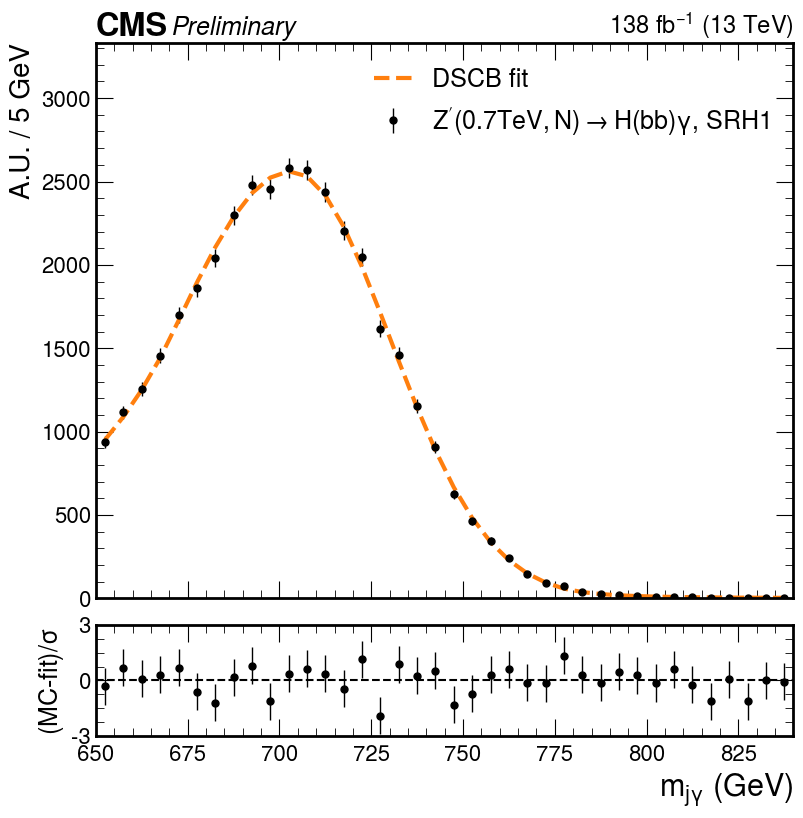

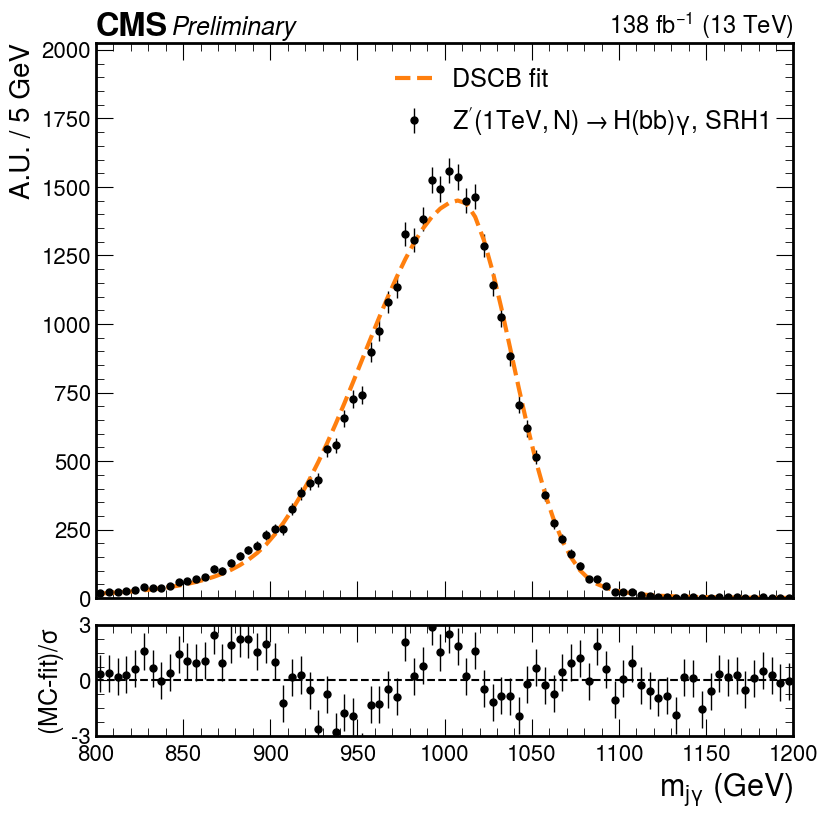

/tmp/ipykernel_1944328/977574805.py:35: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_1944328/3962849870.py:67: RuntimeWarning: invalid value encountered in divide
  norm = np.sum((h*fit/error/error)[error>0]) / np.sum((fit*fit/error/error)[error>0])
/tmp/ipykernel_1944328/3962849870.py:67: RuntimeWarning: divide by zero encountered in divide
  norm = np.sum((h*fit/error/error)[error>0]) / np.sum((fit*fit/error/error)[error>0])
/tmp/ipykernel_1944328/3962849870.py:74: RuntimeWarning: divide by zero encountered in divide
  pull = np.where(error>0, (h - fit)/error, 0)


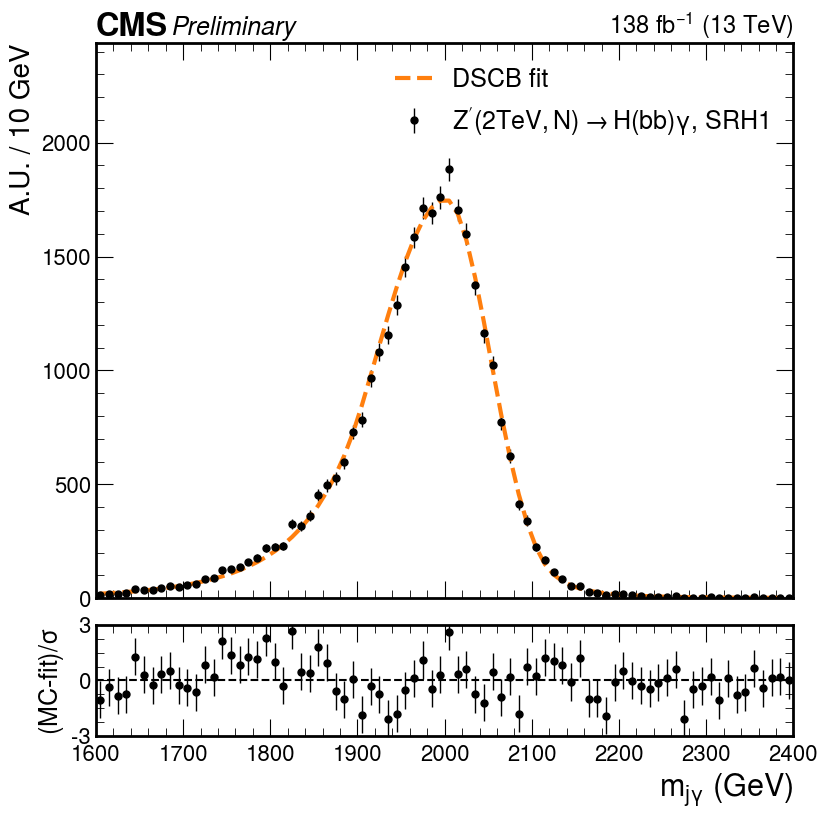

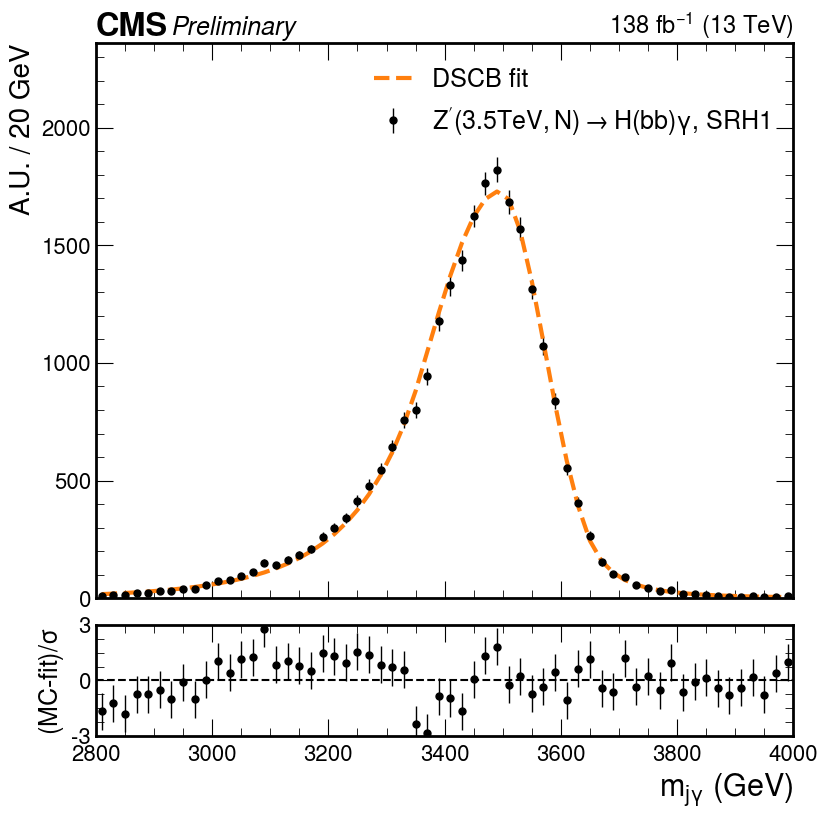

/tmp/ipykernel_1944328/977574805.py:35: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_1944328/3962849870.py:67: RuntimeWarning: invalid value encountered in divide
  norm = np.sum((h*fit/error/error)[error>0]) / np.sum((fit*fit/error/error)[error>0])
/tmp/ipykernel_1944328/3962849870.py:67: RuntimeWarning: divide by zero encountered in divide
  norm = np.sum((h*fit/error/error)[error>0]) / np.sum((fit*fit/error/error)[error>0])
/tmp/ipykernel_1944328/3962849870.py:74: RuntimeWarning: divide by zero encountered in divide
  pull = np.where(error>0, (h - fit)/error, 0)


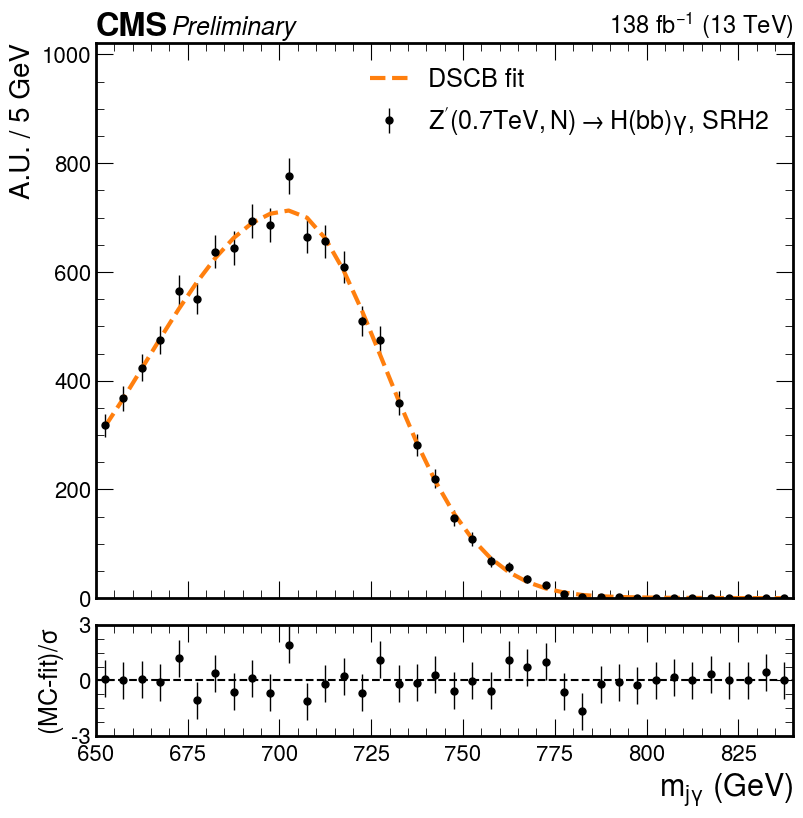

/tmp/ipykernel_1944328/977574805.py:35: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_1944328/3962849870.py:67: RuntimeWarning: invalid value encountered in divide
  norm = np.sum((h*fit/error/error)[error>0]) / np.sum((fit*fit/error/error)[error>0])
/tmp/ipykernel_1944328/3962849870.py:67: RuntimeWarning: divide by zero encountered in divide
  norm = np.sum((h*fit/error/error)[error>0]) / np.sum((fit*fit/error/error)[error>0])
/tmp/ipykernel_1944328/3962849870.py:74: RuntimeWarning: divide by zero encountered in divide
  pull = np.where(error>0, (h - fit)/error, 0)


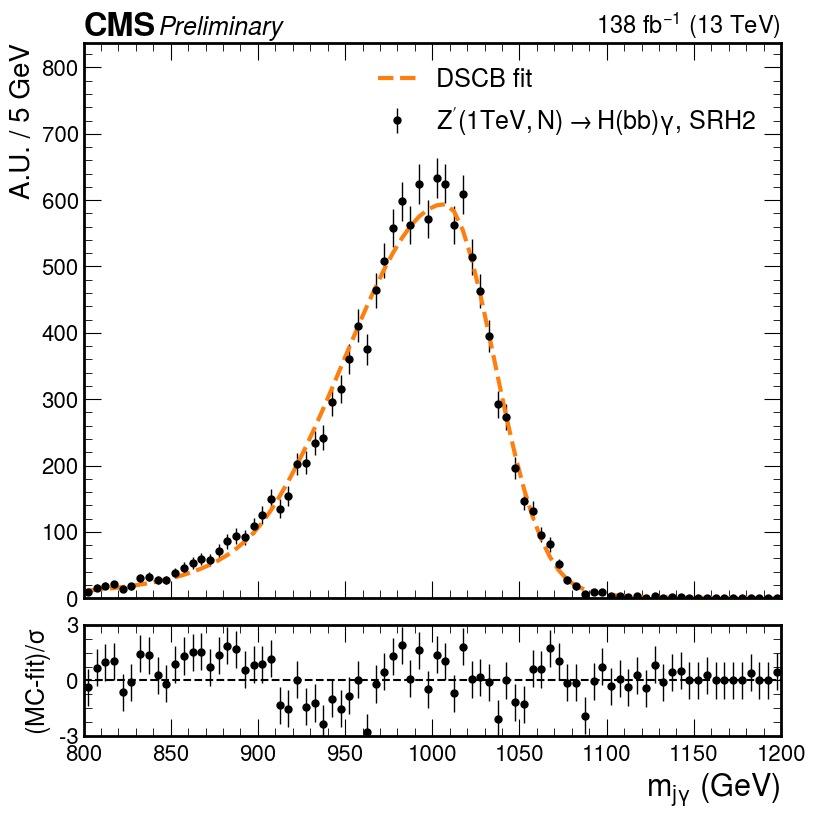

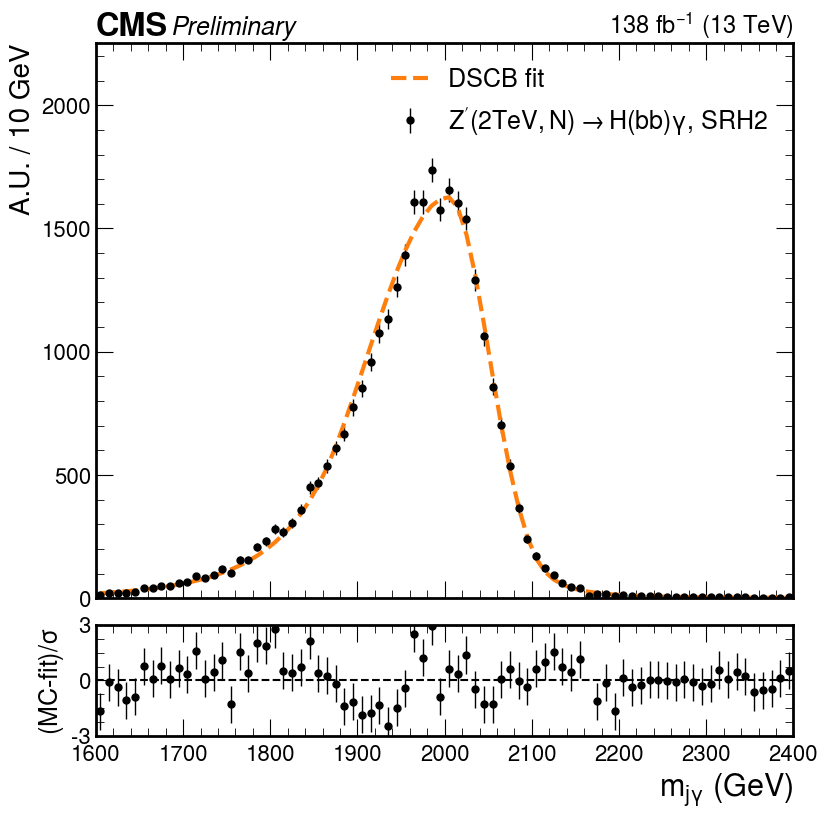

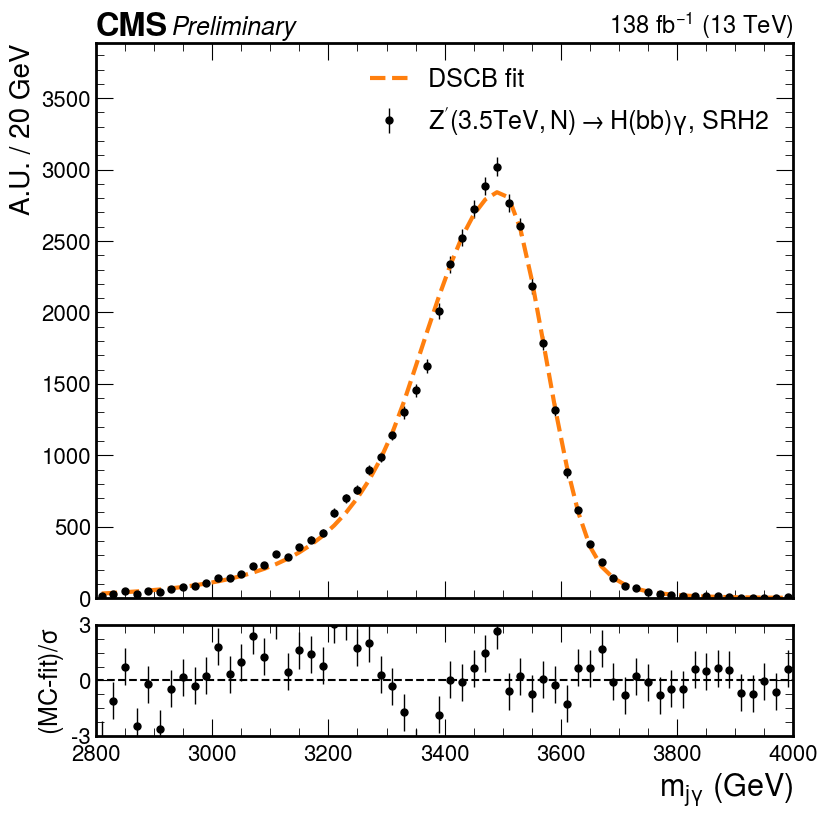

In [86]:
y='Run2'

y='Run2'
for SR in ['SR1', 'SR2']:
    SR_cut=f"""((events[y][k].jet_mass > 110) & (events[y][k].jet_mass < 150) & (events[y][k].tagger > {tagger_cut['down'][SR]}) &  (events[y][k].tagger < {tagger_cut['up'][SR]}))"""
    for m in [0.7, 1, 2, 3.5]:
        mass = round(m*1e3)
        k=r'$Z^\prime('+str(m)+r'TeV,N)\to H(bb)\gamma$'
        signal_region = SR[:2] + ('H' if 'H(bb)' in k else 'Z') + SR[2:]
        path = f'workspace/{y}/{mass}/signal_{signal_region}.yaml'
        with open(os.path.join(os.getcwd(), 'fit' if 'fit' not in os.getcwd() else '', path), 'r', encoding='utf-8') as f:
            fit_info = yaml.safe_load(f)
        arrays={k: events[y][k].fit_mass[eval(SR_cut)]}
        _weight = {k: events[y][k].weight[eval(SR_cut)]}
        bin_width = {0.7: 5, 1: 5, 2: 10, 3.5: 20}
        signal_fit(arrays=arrays, weight=_weight, signal_region=signal_region, plot_name=f'{signal_region}_{mass}', bin_width=bin_width[m], x_min=max(650, 0.8*mass), x_max=min(4000, 1.2*mass), year=y, function=crystal_ball, 
                parameters={k: v for k, v in fit_info.items() if k not in ['mean', 'widthL', 'widthR', 'norm', 'sigma']})


## Zgamma narrow

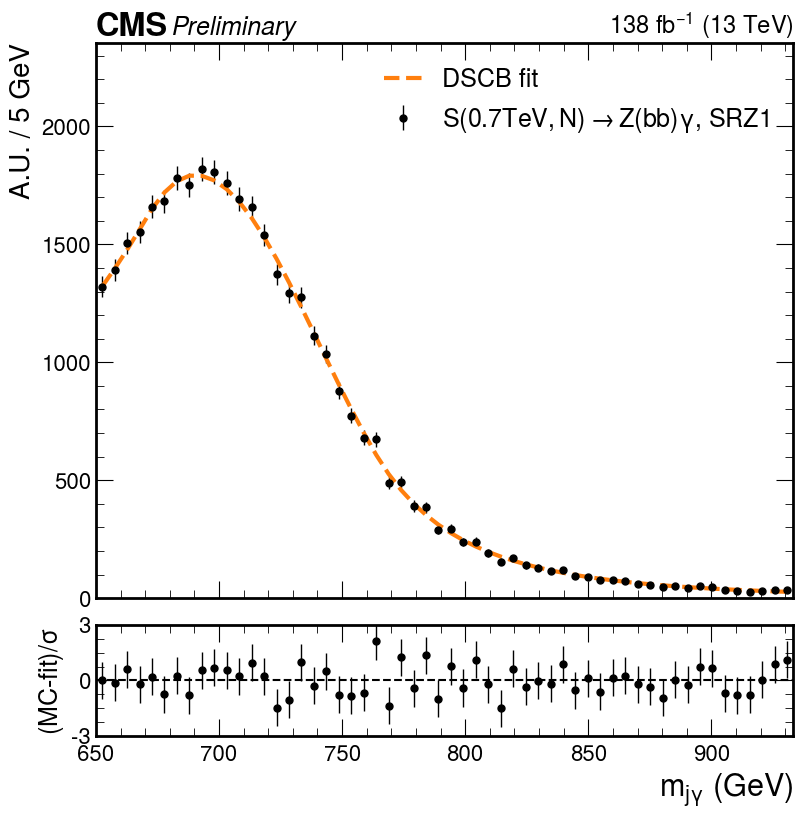

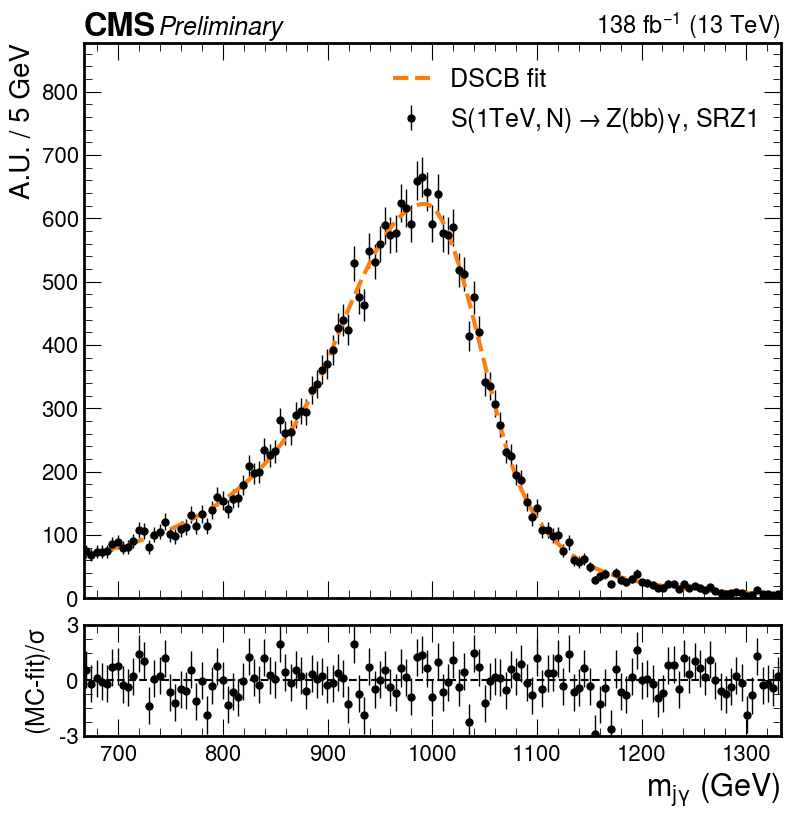

/tmp/ipykernel_1944328/977574805.py:35: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_1944328/3962849870.py:67: RuntimeWarning: invalid value encountered in divide
  norm = np.sum((h*fit/error/error)[error>0]) / np.sum((fit*fit/error/error)[error>0])
/tmp/ipykernel_1944328/3962849870.py:67: RuntimeWarning: divide by zero encountered in divide
  norm = np.sum((h*fit/error/error)[error>0]) / np.sum((fit*fit/error/error)[error>0])
/tmp/ipykernel_1944328/3962849870.py:74: RuntimeWarning: divide by zero encountered in divide
  pull = np.where(error>0, (h - fit)/error, 0)


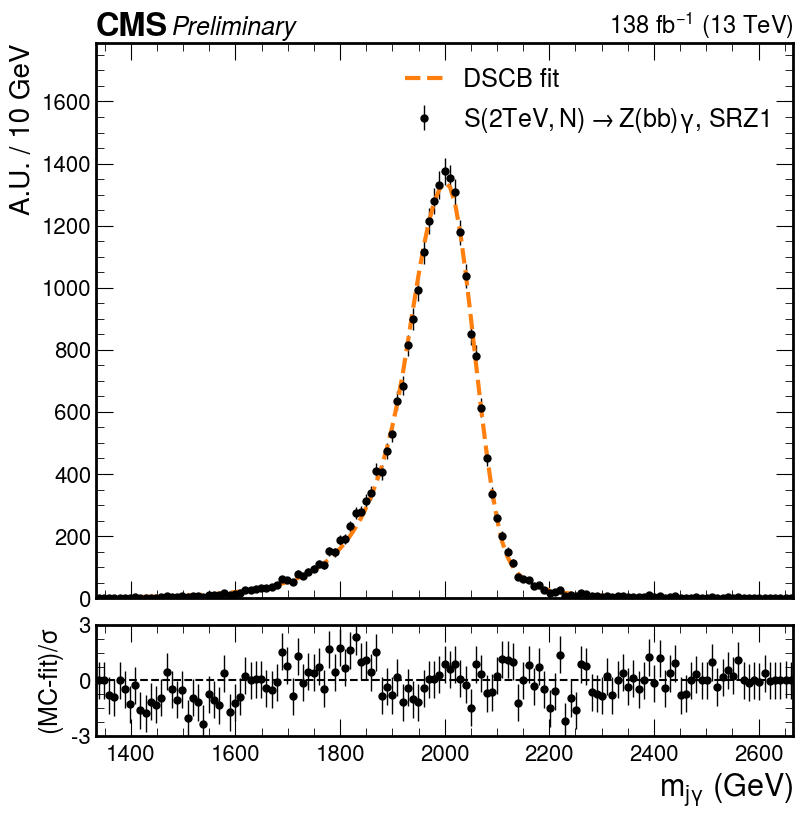

/tmp/ipykernel_1944328/977574805.py:35: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_1944328/3962849870.py:67: RuntimeWarning: invalid value encountered in divide
  norm = np.sum((h*fit/error/error)[error>0]) / np.sum((fit*fit/error/error)[error>0])
/tmp/ipykernel_1944328/3962849870.py:67: RuntimeWarning: divide by zero encountered in divide
  norm = np.sum((h*fit/error/error)[error>0]) / np.sum((fit*fit/error/error)[error>0])
/tmp/ipykernel_1944328/3962849870.py:74: RuntimeWarning: divide by zero encountered in divide
  pull = np.where(error>0, (h - fit)/error, 0)


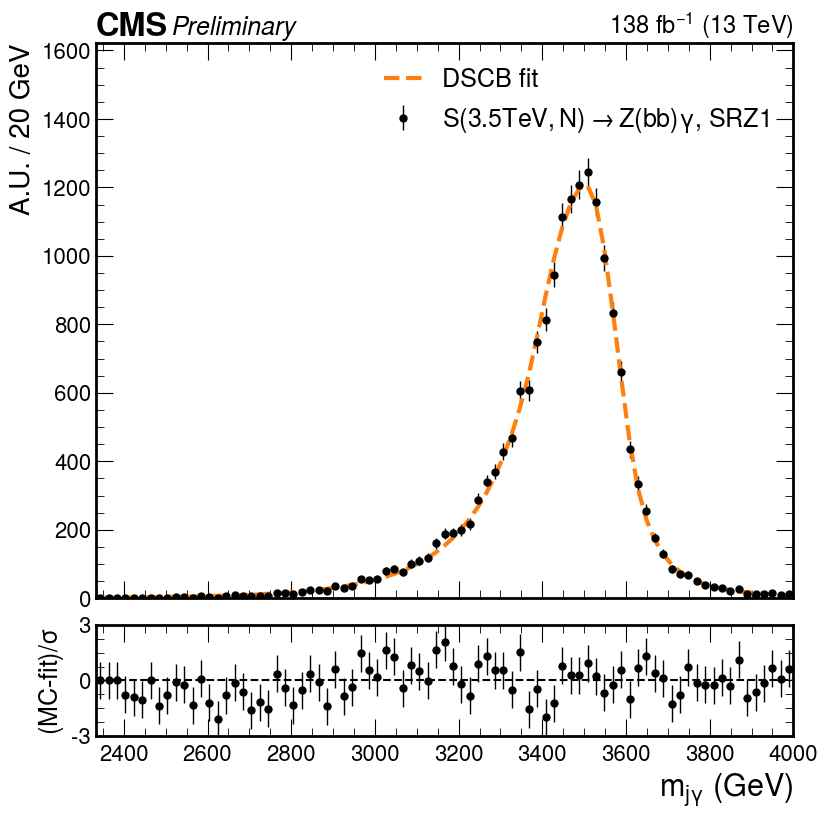

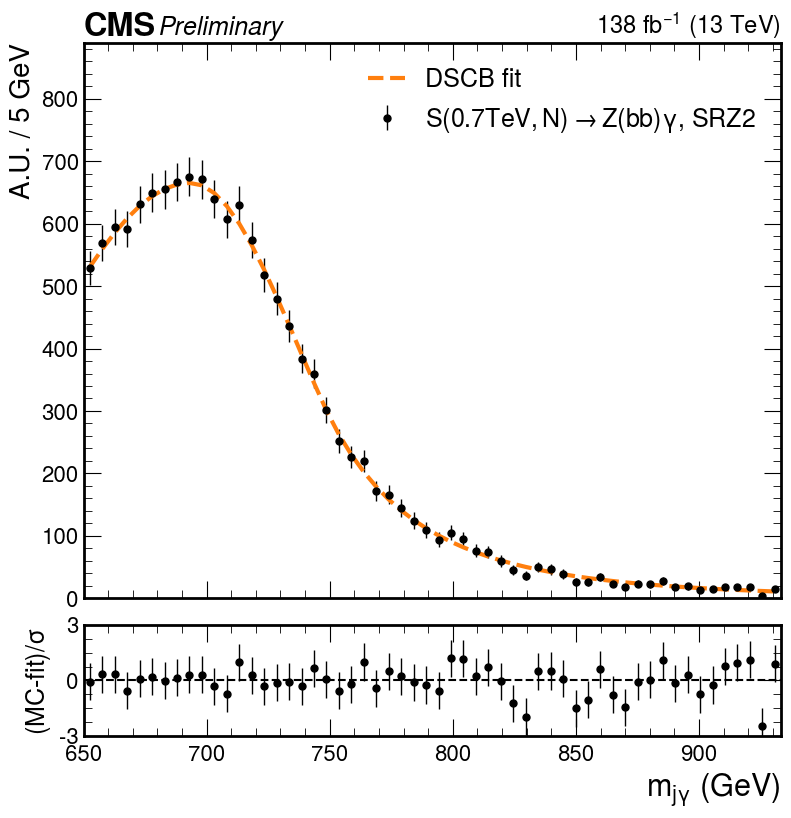

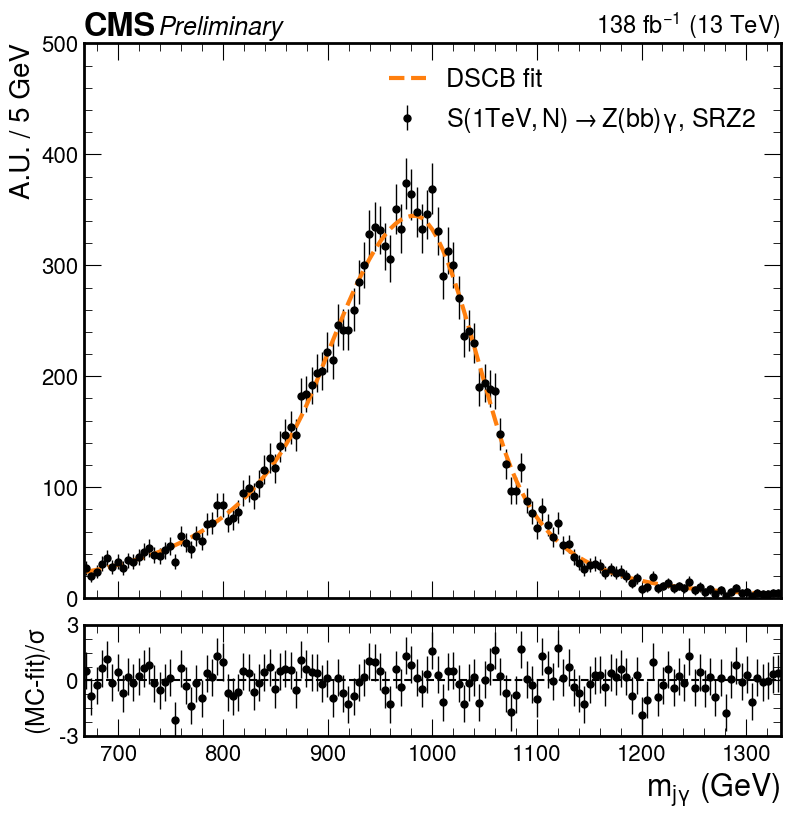

/tmp/ipykernel_1944328/977574805.py:35: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_1944328/3962849870.py:67: RuntimeWarning: invalid value encountered in divide
  norm = np.sum((h*fit/error/error)[error>0]) / np.sum((fit*fit/error/error)[error>0])
/tmp/ipykernel_1944328/3962849870.py:67: RuntimeWarning: divide by zero encountered in divide
  norm = np.sum((h*fit/error/error)[error>0]) / np.sum((fit*fit/error/error)[error>0])
/tmp/ipykernel_1944328/3962849870.py:74: RuntimeWarning: divide by zero encountered in divide
  pull = np.where(error>0, (h - fit)/error, 0)


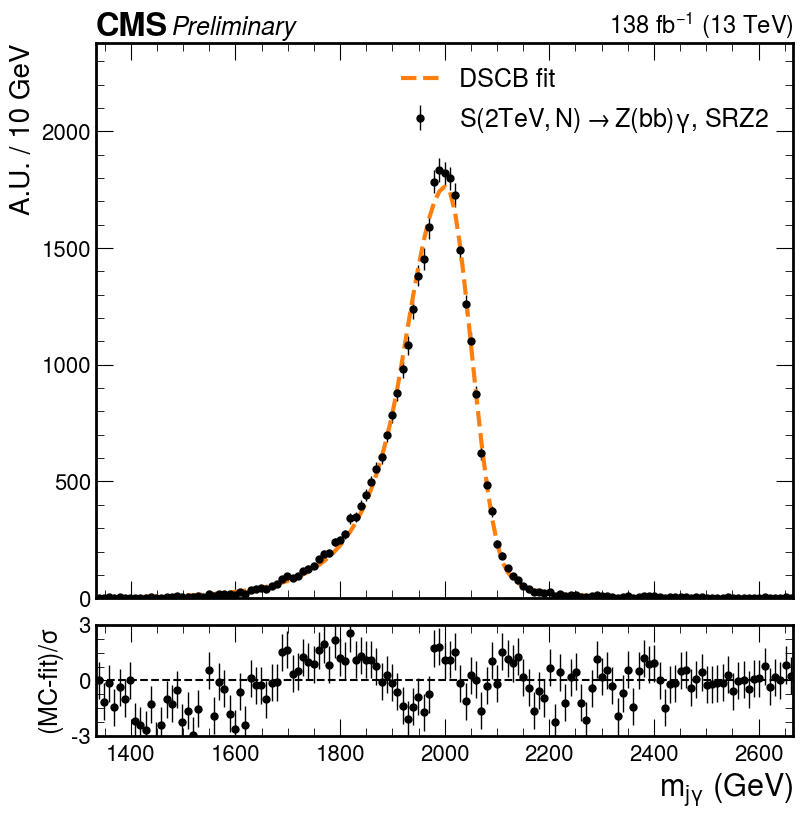

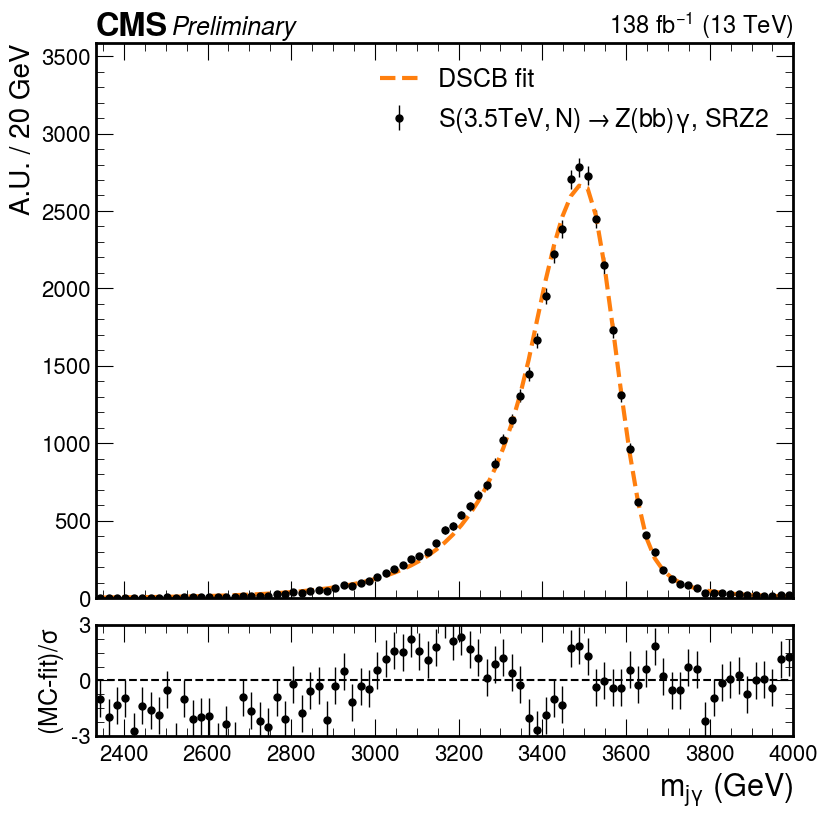

In [87]:
y='Run2'
for SR in ['SR1', 'SR2']:
    SR_cut=f"""((events[y][k].jet_mass > 80) & (events[y][k].jet_mass < 110) & (events[y][k].tagger > {tagger_cut['down'][SR]}) &  (events[y][k].tagger < {tagger_cut['up'][SR]}))"""
    for m in [0.7, 1, 2, 3.5]:
        mass = round(m*1e3)
        k=r'$S('+str(m)+r'TeV,N)\to Z(bb)\gamma$'
        signal_region = SR[:2] + ('H' if 'H(bb)' in k else 'Z') + SR[2:]
        path = f'workspace/{y}/{mass}/signal_{signal_region}.yaml'
        with open(os.path.join(os.getcwd(), 'fit' if 'fit' not in os.getcwd() else '', path), 'r', encoding='utf-8') as f:
            fit_info = yaml.safe_load(f)
        arrays={k: events[y][k].fit_mass[eval(SR_cut)]}
        _weight = {k: events[y][k].weight[eval(SR_cut)]}
        bin_width = {0.7: 5, 1: 5, 2: 10, 3.5: 20}
        signal_fit(arrays=arrays, weight=_weight, signal_region=signal_region, plot_name=f'{signal_region}_{mass}', bin_width=bin_width[m], x_min=max(650, 2/3*mass), x_max=min(4000, 4/3*mass), year=y, function=crystal_ball, 
                parameters={k: v for k, v in fit_info.items() if k not in ['mean', 'widthL', 'widthR', 'norm', 'sigma']})

## Zgamma wide

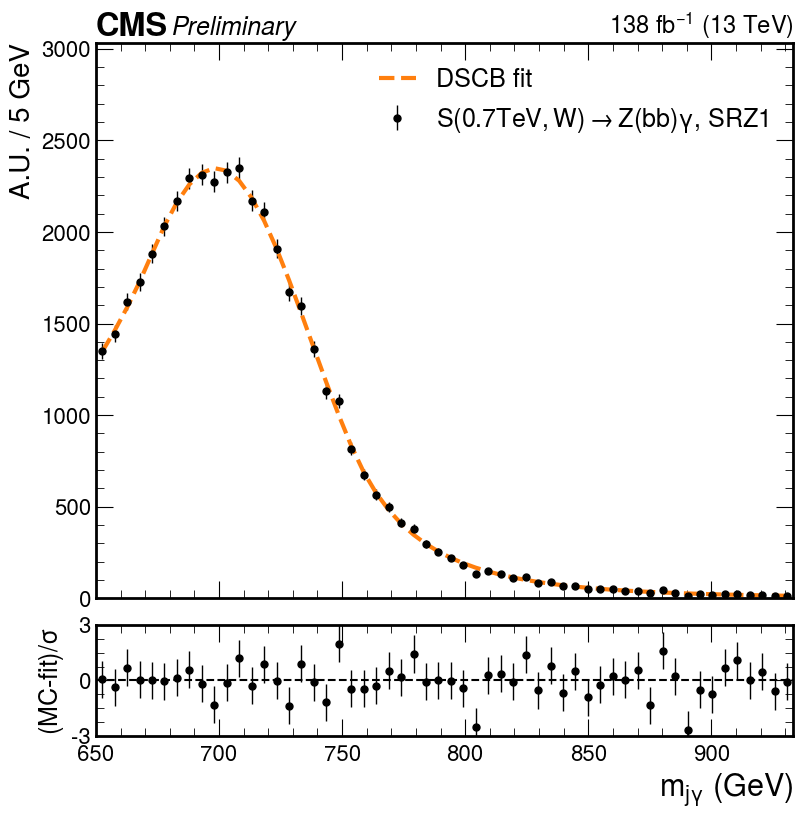

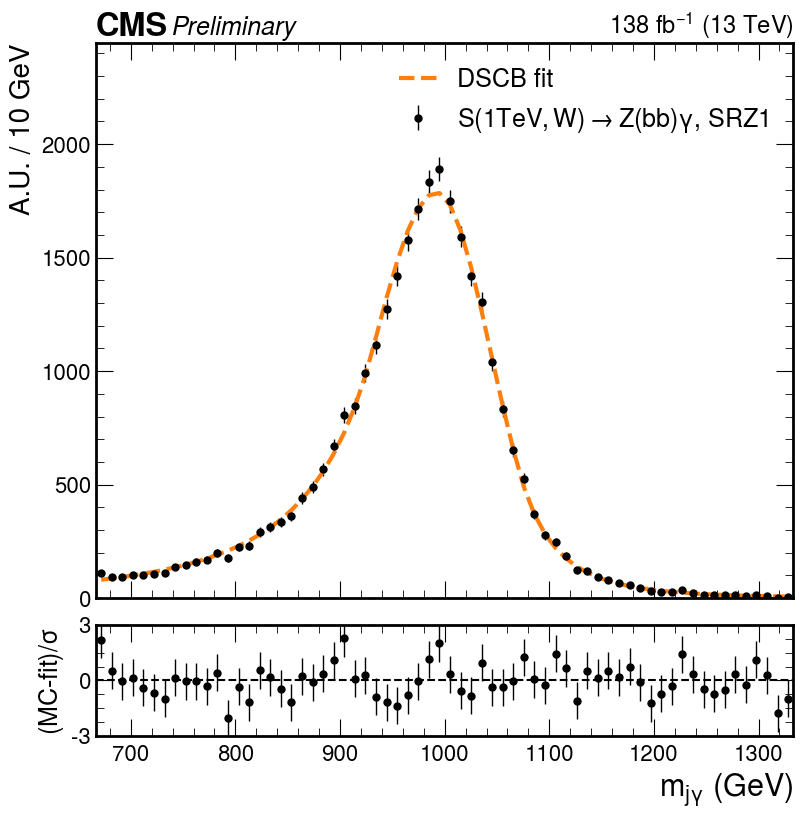

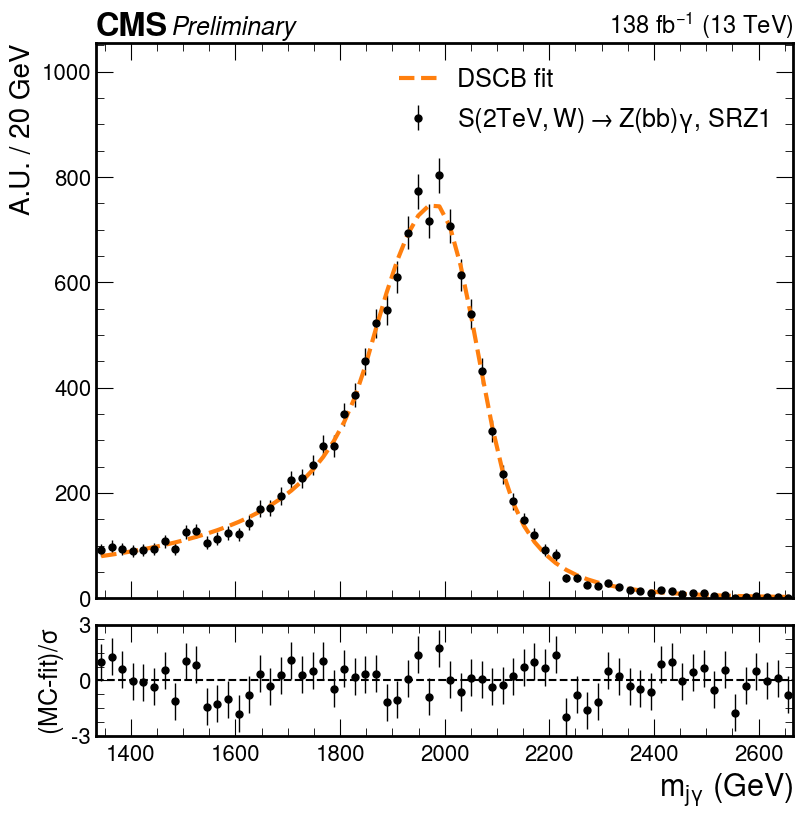

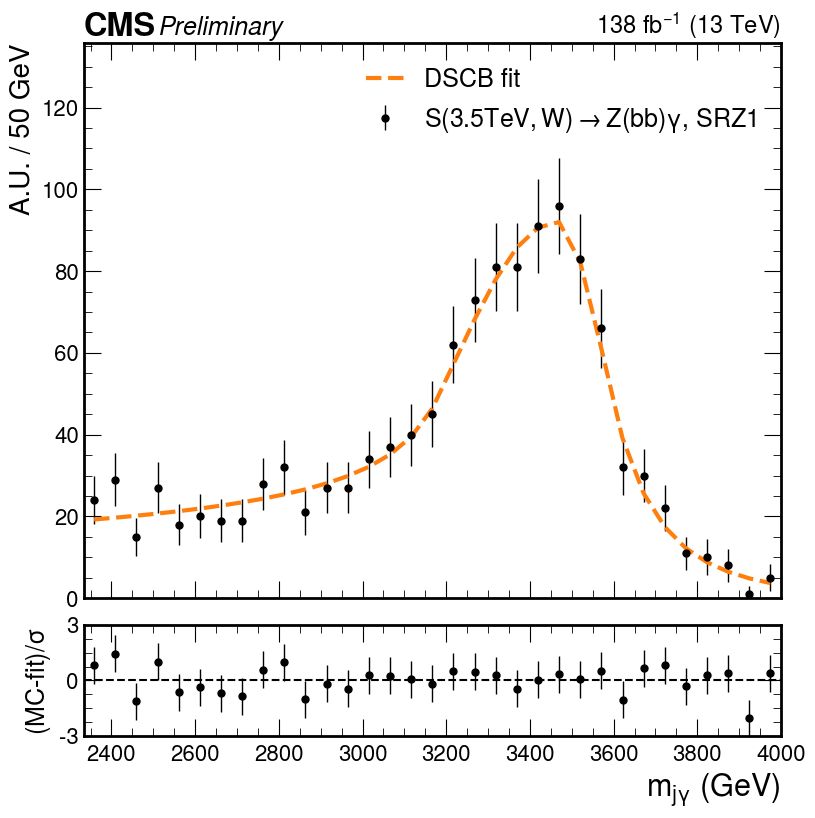

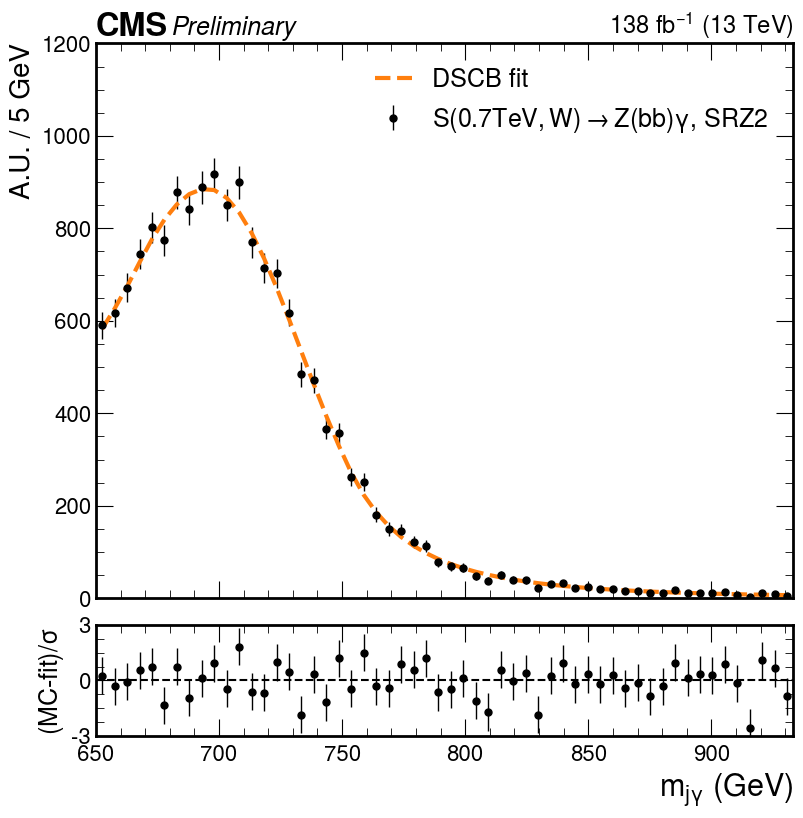

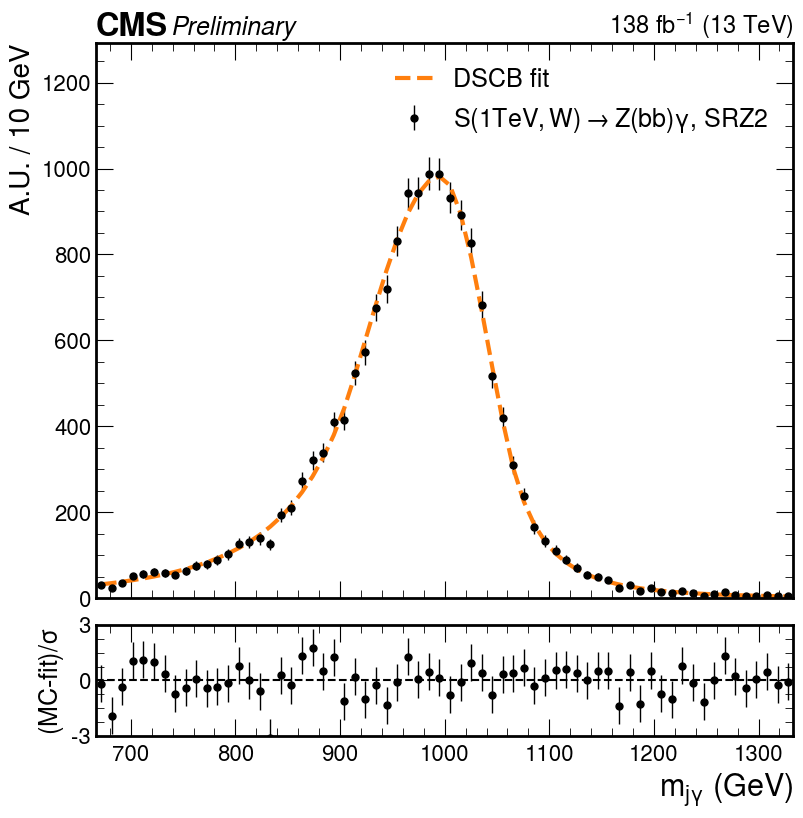

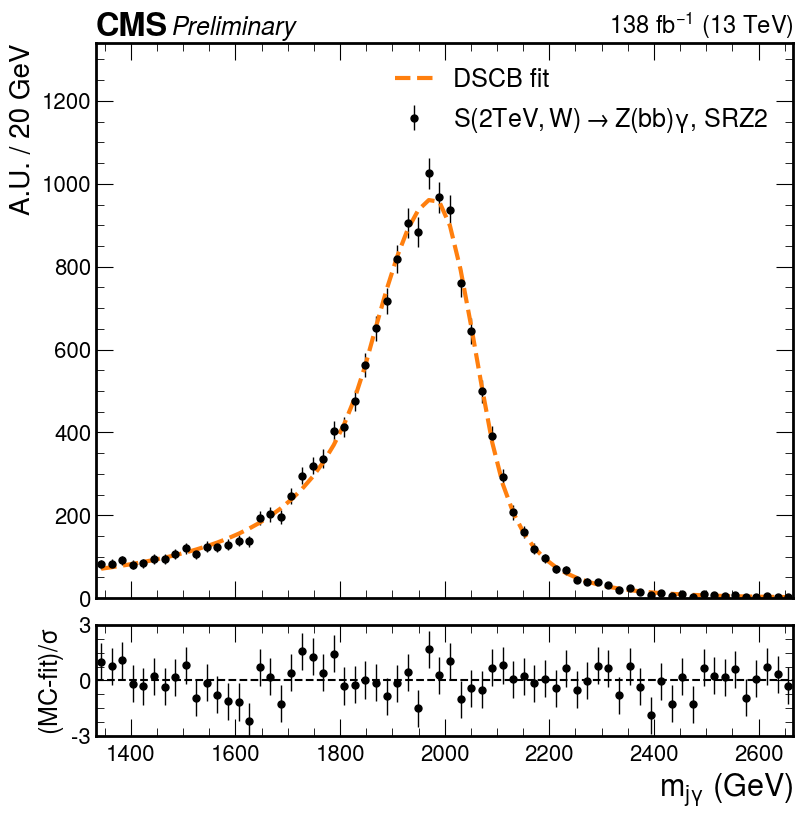

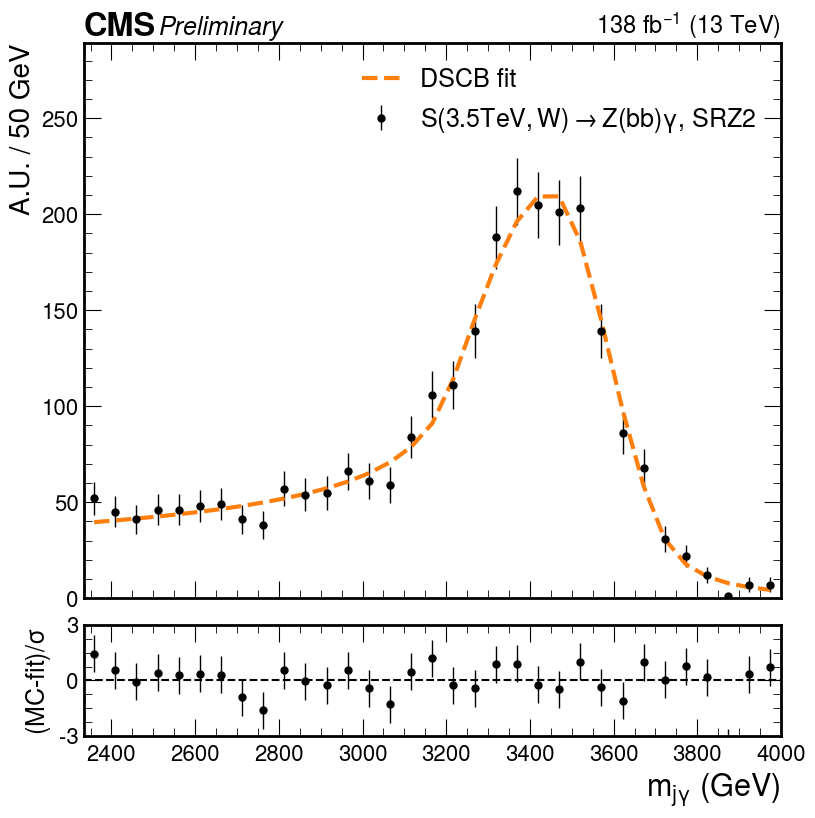

In [91]:
y='Run2'
for SR in ['SR1', 'SR2']:
    SR_cut=f"""((events[y][k].jet_mass > 80) & (events[y][k].jet_mass < 110) & (events[y][k].tagger > {tagger_cut['down'][SR]}) &  (events[y][k].tagger < {tagger_cut['up'][SR]}))"""
    for m in [0.7, 1, 2, 3.5]:
        mass = round(m*1e3)
        k=r'$S('+str(m)+r'TeV,W)\to Z(bb)\gamma$'
        signal_region = SR[:2] + ('H' if 'H(bb)' in k else 'Z') + SR[2:]
        path = f'workspace/{y}/{mass}_5p6/signal_{signal_region}.yaml'
        with open(os.path.join(os.getcwd(), 'fit' if 'fit' not in os.getcwd() else '', path), 'r', encoding='utf-8') as f:
            fit_info = yaml.safe_load(f)
        arrays={k: events[y][k].fit_mass[eval(SR_cut)]}
        _weight = {k: events[y][k].weight[eval(SR_cut)]}
        bin_width = {0.7: 5, 1: 10, 2: 20, 3.5: 50}
        signal_fit(arrays=arrays, weight=_weight, signal_region=signal_region, plot_name=f'{signal_region}_W_{mass}', bin_width=bin_width[m], x_min=max(650, 2/3*mass), x_max=min(4000, 4/3*mass), year=y, function=crystal_ball, 
                parameters={k: v for k, v in fit_info.items() if k not in ['mean', 'widthL', 'widthR', 'norm', 'sigma']})

## Zgamma very wide

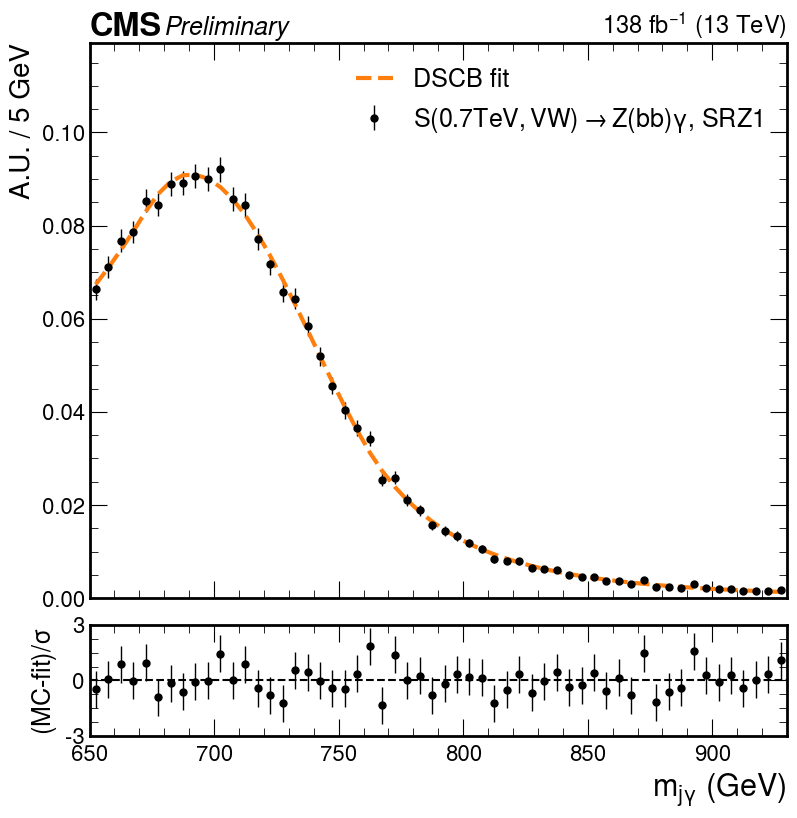

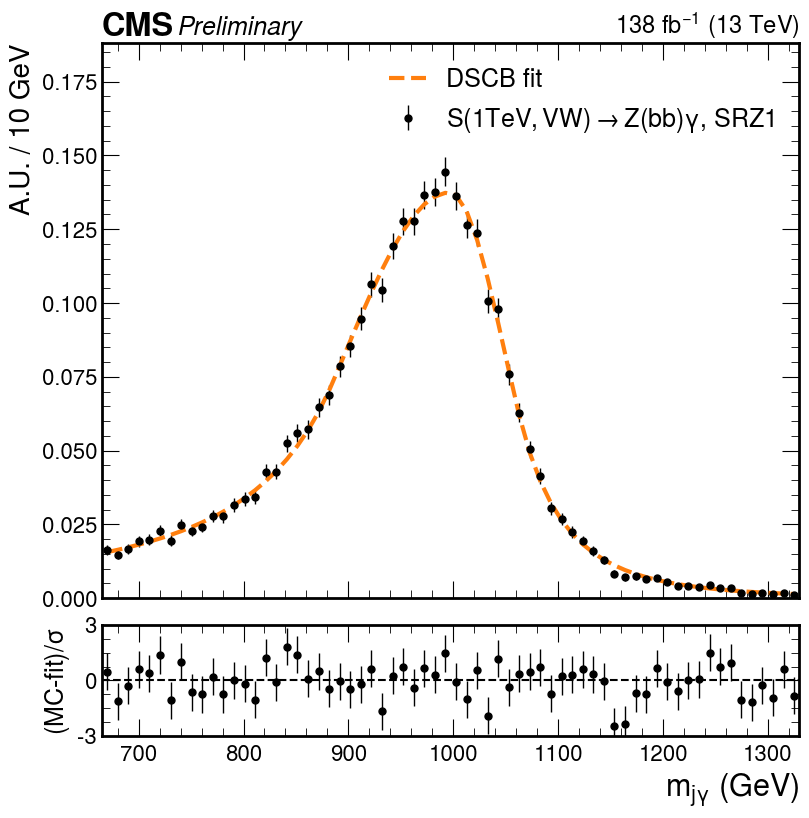

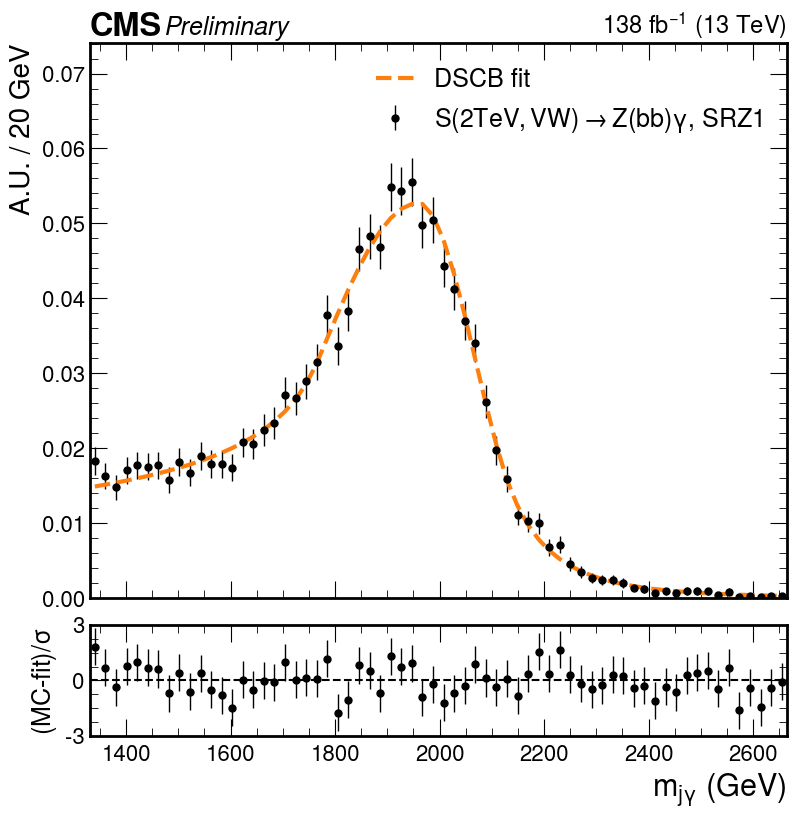

/tmp/ipykernel_1944328/977574805.py:35: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_1944328/3962849870.py:67: RuntimeWarning: invalid value encountered in divide
  norm = np.sum((h*fit/error/error)[error>0]) / np.sum((fit*fit/error/error)[error>0])
/tmp/ipykernel_1944328/3962849870.py:67: RuntimeWarning: divide by zero encountered in divide
  norm = np.sum((h*fit/error/error)[error>0]) / np.sum((fit*fit/error/error)[error>0])
/tmp/ipykernel_1944328/3962849870.py:74: RuntimeWarning: divide by zero encountered in divide
  pull = np.where(error>0, (h - fit)/error, 0)


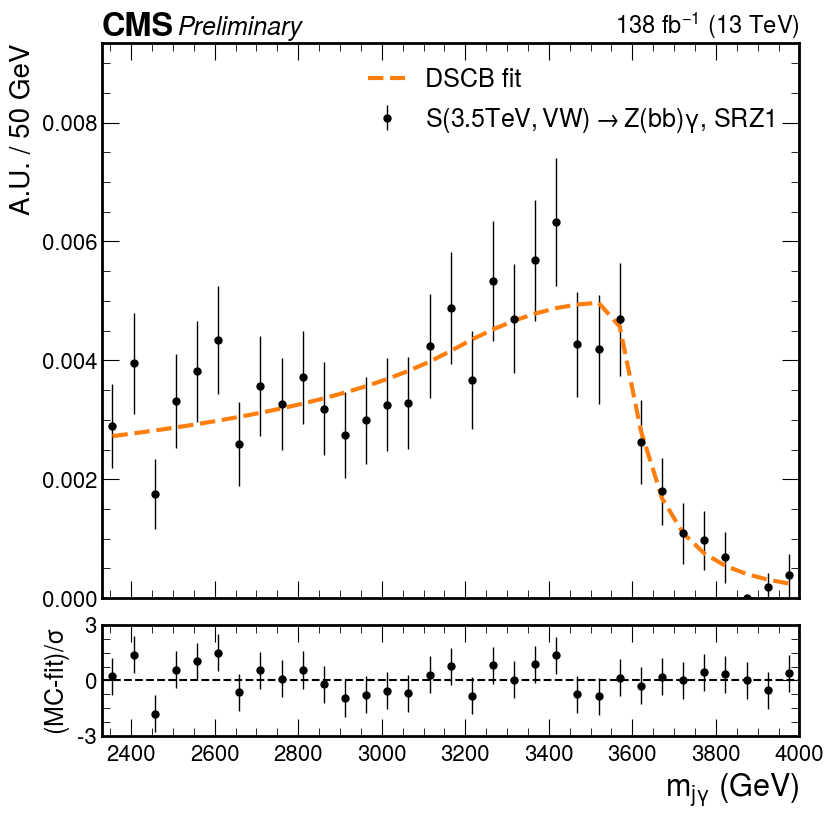

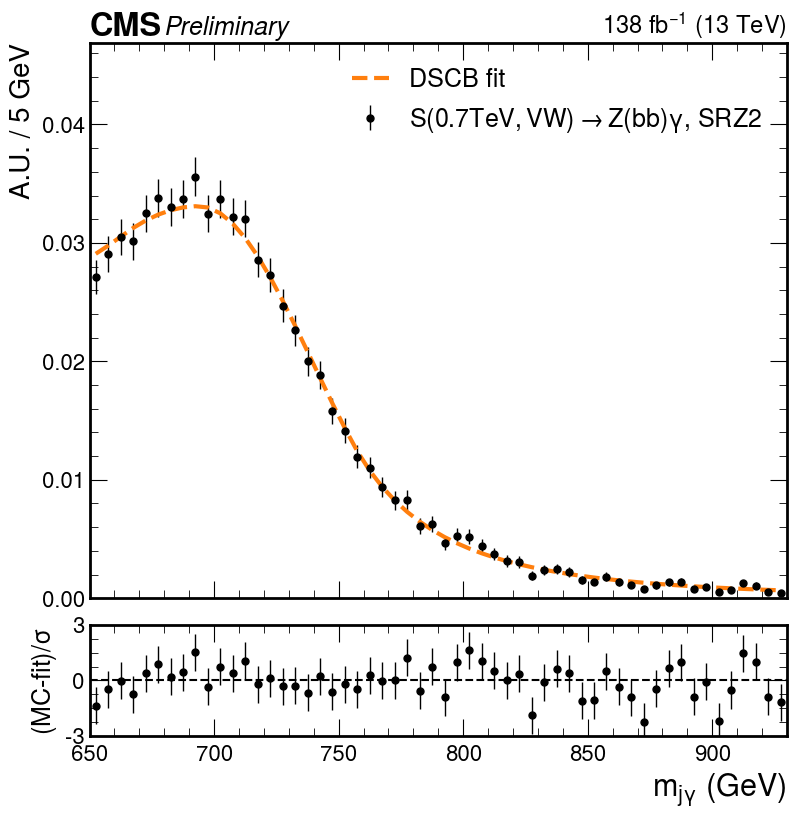

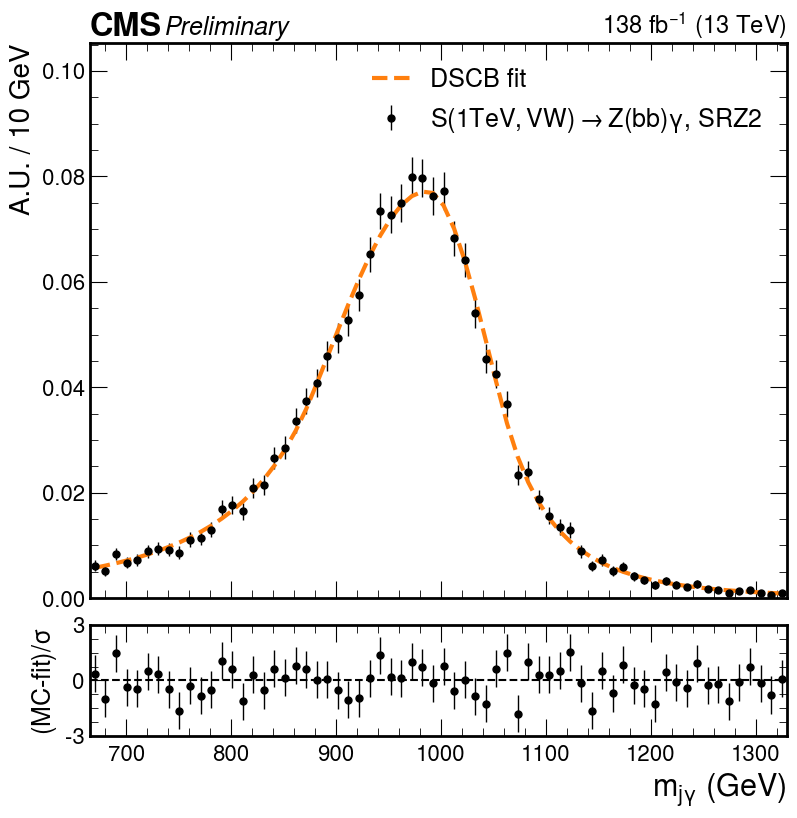

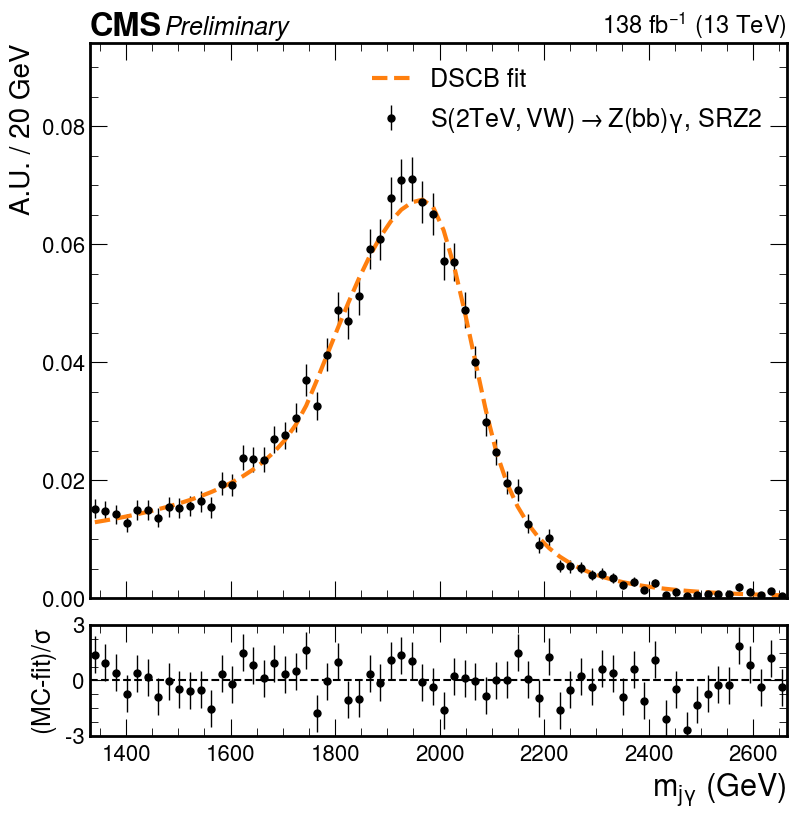

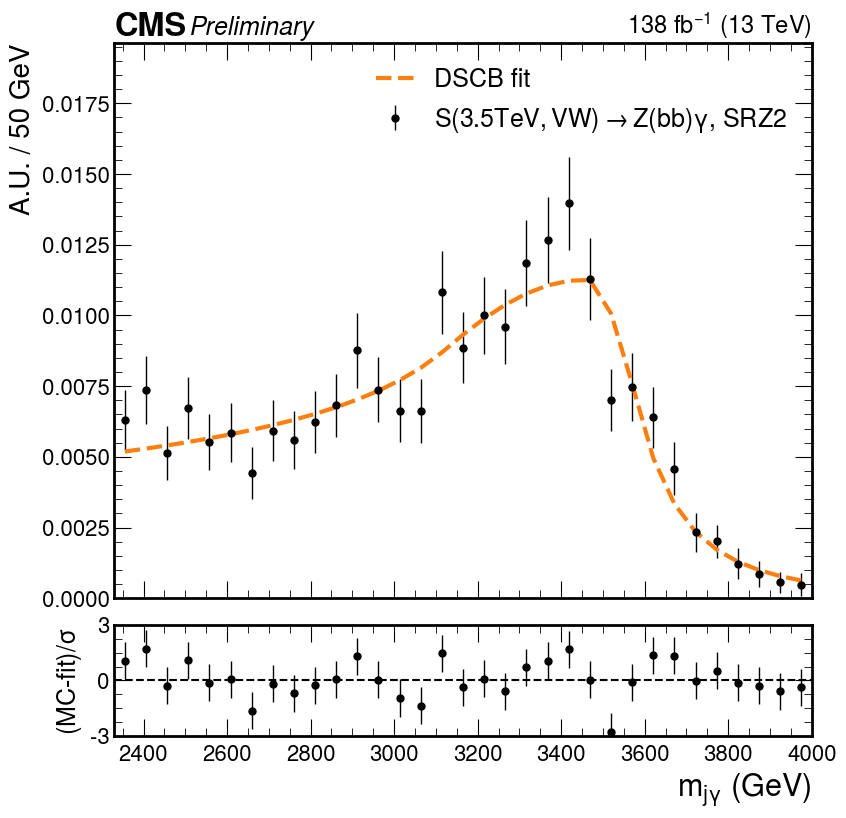

In [90]:
y='Run2'
for SR in ['SR1', 'SR2']:
    SR_cut=f"""((events[y][k].jet_mass > 80) & (events[y][k].jet_mass < 110) & (events[y][k].tagger > {tagger_cut['down'][SR]}) &  (events[y][k].tagger < {tagger_cut['up'][SR]}))"""
    for m in [0.7, 1, 2, 3.5]:
        mass = round(m*1e3)
        k=r'$S('+str(m)+r'TeV,VW)\to Z(bb)\gamma$'
        signal_region = SR[:2] + ('H' if 'H(bb)' in k else 'Z') + SR[2:]
        path = f'workspace/{y}/{mass}_10p0/signal_{signal_region}.yaml'
        with open(os.path.join(os.getcwd(), 'fit' if 'fit' not in os.getcwd() else '', path), 'r', encoding='utf-8') as f:
            fit_info = yaml.safe_load(f)
        arrays={k: events[y][k].fit_mass[eval(SR_cut)]}
        _weight = {k: events[y][k].weight[eval(SR_cut)]}
        bin_width = {0.7: 5, 1: 10, 2: 20, 3.5: 50}
        signal_fit(arrays=arrays, weight=_weight, signal_region=signal_region, plot_name=f'{signal_region}_VW_{mass}', bin_width=bin_width[m], x_min=max(650, 2/3*mass//5*5), x_max=min(4000, 4/3*mass//5*5), year=y, function=crystal_ball, 
                parameters={k: v for k, v in fit_info.items() if k not in ['mean', 'widthL', 'widthR', 'norm', 'sigma']})

In [ ]:
def fit_signal(year, jet, signal_mass, region, cut):
    signal_region = region[:2]+jet+region[2:]
    m = int(str(signal_mass).split('_')[0])

    with open('../src/parameters/uncertainty/systematics.yaml', 'r', encoding='utf-8') as f:
        systematics = yaml.safe_load(f)

    if '_' in str(signal_mass):
        sigma = m * (0.056 if '_5p6' in signal_mass else 0.10)
    else:
        f = uproot.open(f"input/{year}/{signal_mass}/bbgamma_SR{jet}.root")
        sigma = np.std(f['Events']['fit_mass'].array())

    ## Signal modeling
    f = ROOT.TFile(f"input/{year}/{signal_mass}/bbgamma_SR{jet}.root", "r")
    # Load TTree
    tree = f.Get("Events")

    # Define mass and weight variables
    fit_mass = ROOT.RooRealVar("fit_mass", "fit_mass", m, 650, 4000)
    weight = ROOT.RooRealVar("weight", "weight", 0.1, 0, 100)
    jet_mass = ROOT.RooRealVar("jet_mass", "jet_mass", 125, 0, 999)
    tagger = ROOT.RooRealVar("tagger", "tagger", 0.5, 0, 2)
    fit_mass.setRange("fit_range", max(650, 2*m/3), min(4000, 4*m/3))

    # Convert to RooDataSet
    mc = ROOT.RooDataSet("signal", "signal", tree, ROOT.RooArgSet(fit_mass, weight, jet_mass, tagger), cut, "weight")

    # Introduce RooRealVars into the workspace for the fitted variable
    x0 = ROOT.RooRealVar("x0", "x0", m, m - 50, m + 50)
    sigmaL = ROOT.RooRealVar("sigmaL", "sigmaL", sigma, 10, 5*sigma)
    sigmaR = ROOT.RooRealVar("sigmaR", "sigmaR", sigma, 10, 5*sigma)
    alphaL = ROOT.RooRealVar("alphaL", "alphaL", 1, 0.1, 5)
    alphaR = ROOT.RooRealVar("alphaR", "alphaR", 1, 0.1, 5)
    nL = ROOT.RooRealVar("nL", "nL", 2, 1, 4.5)
    nR = ROOT.RooRealVar("nR", "nR", 2, 1, 4.5)

    if year != 'Run2':
        JES = ROOT.RooRealVar(f"JES_{year}", f"JES_{year}", 0, -5, 5)
    else:
        JES = ROOT.RooRealVar("JES", f"JES", 0, -5, 5)
    JER = ROOT.RooRealVar("JER", "JER", 0, -5, 5)
    PES = ROOT.RooRealVar("PES", "PES", 0, -5, 5)
    PER = ROOT.RooRealVar("PER", "PER", 0, -5, 5)
    JES.setConstant(True); JER.setConstant(True); PES.setConstant(True); PER.setConstant(True)
    jes = systematics['JES'][region][m]-1
    mean = ROOT.RooFormulaVar("mean", "mean", 
        "@0*(1+%f*@1+%f*@2)"%(jes*(10 if year=='2018' else 1), (systematics['PES'][region][m]-1)/2), 
        ROOT.RooArgList(x0, JES, PES))
    widthL = ROOT.RooFormulaVar("widthL", "widthL", 
        "@0*(1+%f*@1+%f*@2)"%(systematics['JER'][region][jet][signal_mass]-1, systematics['PER'][region][jet][signal_mass]-1), 
        ROOT.RooArgList(sigmaL, JER, PER))
    widthR = ROOT.RooFormulaVar("widthR", "widthR", 
        "@0*(1+%f*@1+%f*@2)"%(systematics['JER'][region][jet][signal_mass]-1, systematics['PER'][region][jet][signal_mass]-1),
        ROOT.RooArgList(sigmaR, JER, PER))

    # Define the Gaussian with mean=MH and width=sigma
    model_signal = ROOT.RooCrystalBall(f"model_bbgamma_{signal_region}", f"model_bbgamma_{signal_region}", fit_mass, mean, widthL, widthR, alphaL, nL, alphaR, nR)
    signal_norm = ROOT.RooRealVar(f"model_bbgamma_{signal_region}_norm", f"Number of signal events in {signal_region}", mc.sumEntries(), 1e-3, 5*mc.sumEntries())

    # Fit Gaussian to MC events and plot
    model_signal.fitTo(mc, ROOT.RooFit.Range('fit_range'),  ROOT.RooFit.PrintLevel(-1), ROOT.RooFit.SumW2Error(True))

    x0.setConstant(True)
    sigmaL.setConstant(True)
    sigmaR.setConstant(True)
    alphaL.setConstant(True)
    alphaR.setConstant(True)
    nL.setConstant(True)
    nR.setConstant(True)
    #signal_norm.setConstant(True)

    sig_model_dir = f'workspace/{year}/{signal_mass}'
    os.makedirs(sig_model_dir, exist_ok=True)
    f_out = ROOT.TFile(f"{sig_model_dir}/signal_{signal_region}.root", "RECREATE")
    w_sig = ROOT.RooWorkspace("workspace_signal", "workspace_signal")
    getattr(w_sig, "import")(model_signal)
    #getattr(w_sig, "import")(signal_norm)
    w_sig.Print()
    w_sig.Write()
    f_out.Close()

    with open(f'{sig_model_dir}/signal_{signal_region}.yaml', 'w', encoding='utf-8') as f:
        info = {
            'x0': x0.getVal(),
            'mean': mean.getVal(),
            'sigmaL': sigmaL.getVal(),
            'widthL': widthL.getVal(),
            'sigmaR': sigmaR.getVal(),
            'widthR': widthR.getVal(),
            'alphaL': alphaL.getVal(),
            'alphaR': alphaR.getVal(),
            'nL': nL.getVal(),
            'nR': nR.getVal(),
            'event_sum': mc.sumEntries(),
            'norm': signal_norm.getVal(),
            'sigma': float(sigma)
        }
        yaml.dump(info, f)

# Scratch

In [ ]:
import yaml, uproot
import numpy as np
fatjet = 'H'
signal_mass = 1000
year = 'Run2'
region ='SR2'

m = int(str(signal_mass).split('_')[0])

with open('../src/parameters/uncertainty/systematics.yaml', 'r', encoding='utf-8') as f:
    systematics = yaml.safe_load(f)

f = uproot.open(f"input/{year}/{signal_mass}/{fatjet}bb_gamma.root")
if '_' in str(signal_mass):
    f_narrow = uproot.open(f"input/{year}/{signal_mass.split('_')[0]}/{fatjet}bb_gamma.root")
    sigma = np.std(f_narrow['Events']['fit_mass'].array())
else:
    sigma = np.std(f['Events']['fit_mass'].array())

# # Signal modelling
f = ROOT.TFile(f"input/{year}/{signal_mass}/{fatjet}bb_gamma.root", "r")
# Load TTree
tree = f.Get("Events")

# Define mass and weight variables
if '_' in str(signal_mass):
    fit_mass = ROOT.RooRealVar("fit_mass", "fit_mass", m, m-3*sigma if m-3*sigma>500 else 500, m+3*sigma)
else:
    fit_mass = ROOT.RooRealVar("fit_mass", "fit_mass", m, m-5*sigma if m-5*sigma>500 else 500, m+5*sigma)
weight = ROOT.RooRealVar("weight", "weight", 0.1, 0, 100)
jet_mass = ROOT.RooRealVar("jet_mass", "jet_mass", 125, 0, 999)
tagger = ROOT.RooRealVar("tagger", "tagger", 0.5, 0, 2)

# Convert to RooDataSet

mc = ROOT.RooDataSet("signal", "signal", tree, ROOT.RooArgSet(fit_mass, weight, jet_mass, tagger), cut, "weight")

# Lets plot the signal mass distribution
can = ROOT.TCanvas()
plot = fit_mass.frame()
mc.plotOn(plot)
plot.Draw()
can.Update()
if not os.path.exists(f'../plots/fit/{year}/{signal_mass}'):
    os.makedirs(f'../plots/fit/{year}/{signal_mass}')
can.SaveAs(f"../plots/fit/{year}/{signal_mass}/fit_variable_{fatjet}bb_{signal_mass}_{region}.pdf")

# Introduce RooRealVars into the workspace for the fitted variable
x0 = ROOT.RooRealVar("x0", "x0", m, m - 300, m + 300)
sigmaL = ROOT.RooRealVar("sigmaL", "sigmaL", sigma, 5, 5*sigma)
sigmaR = ROOT.RooRealVar("sigmaR", "sigmaR", sigma, 5, 5*sigma)
alphaL = ROOT.RooRealVar("alphaL", "alphaL", 1, 0.1, 5)
alphaR = ROOT.RooRealVar("alphaR", "alphaR", 1, 0.1, 5)
nL = ROOT.RooRealVar("nL", "nL", 1, 0.2, 3)
nR = ROOT.RooRealVar("nR", "nR", 1, 0.2, 3)

JES = ROOT.RooRealVar("JES", "JES", 0, -5, 5)
JER = ROOT.RooRealVar("JER", "JER", 0, -5, 5)
PES = ROOT.RooRealVar("PES", "PES", 0, -5, 5)
PER = ROOT.RooRealVar("PER", "PER", 0, -5, 5)
JES.setConstant(True); JER.setConstant(True); PES.setConstant(True); PER.setConstant(True)
mean = ROOT.RooFormulaVar("mean", "mean", 
    "@0*(1+%f*@1+%f*@2)"%(systematics['JES'][region][m]-1, systematics['PES'][region][m]-1), 
    ROOT.RooArgList(x0, JES, PES))
widthL = ROOT.RooFormulaVar("widthL", "widthL", 
    "@0*(1+%f*@1+%f*@2)"%(systematics['JER'][region][fatjet][signal_mass]-1, systematics['PER'][region][fatjet][signal_mass]-1), 
    ROOT.RooArgList(sigmaL, JER, PER))
widthR = ROOT.RooFormulaVar("widthR", "widthR", 
    "@0*(1+%f*@1+%f*@2)"%(systematics['JER'][region][fatjet][signal_mass]-1, systematics['PER'][region][fatjet][signal_mass]-1),
    ROOT.RooArgList(sigmaR, JER, PER))

# Define the Gaussian with mean=MH and width=sigma
model_signal = ROOT.RooCrystalBall(f"model_bbgamma_{region}", f"model_bbgamma_{region}", fit_mass, mean, widthL, widthR, alphaL, nL, alphaR, nR)
signal_norm = ROOT.RooRealVar(f"model_bbgamma_{region}_norm", f"Number of signal events in Tag {fatjet}bb+gamma", mc.sumEntries(), 0, 100*mc.sumEntries())

# Fit Gaussian to MC events and plot
model_signal.fitTo(mc, ROOT.RooFit.SumW2Error(True))